In [95]:
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.metrics import  confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import plot_confusion_matrix
from matplotlib.pyplot import figure

import sys
sys.setrecursionlimit(1000000)

In [3]:

!nvidia-smi

Tue Nov  1 07:19:48 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.73.08    Driver Version: 510.73.08    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Quadro GP100        On   | 00000000:17:00.0 Off |                    0 |
| 33%   49C    P0    33W / 235W |      4MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Quadro GP100        On   | 00000000:65:00.0 Off |                    0 |
| 33%   

In [4]:
data_frame_train = pd.read_csv("../../csv_files_new_ppi/training_and_test_set/train_set_subset_with_embedding.csv")
data_frame_test = pd.read_csv("../../csv_files_new_ppi/training_and_test_set/test_set_subset_with_embedding.csv")


In [5]:
data_frame_train

,Prot_A_1,Prot_A_2,Prot_A_3,Prot_A_4,Prot_A_5,Prot_A_6,Prot_A_7,Prot_A_8,Prot_A_9,Prot_A_10,...,Prot_B_1016,Prot_B_1017,Prot_B_1018,Prot_B_1019,Prot_B_1020,Prot_B_1021,Prot_B_1022,Prot_B_1023,Prot_B_1024,label
0,0.056950,0.014814,0.123467,0.038978,-0.066684,-0.072988,-0.045733,0.022055,-0.044598,-0.021534,...,-0.011804,-0.080743,0.027482,-0.013952,-0.084208,0.003828,0.000939,-0.020814,-0.051883,0
1,0.122600,-0.016442,0.051898,0.064010,-0.070603,-0.047028,0.018324,0.021974,-0.035130,-0.012670,...,0.056966,-0.029583,0.050276,-0.035236,-0.074482,-0.003541,-0.034869,-0.083177,-0.029516,1
2,0.093352,0.029865,0.090026,0.056597,-0.070872,-0.064602,-0.076780,0.087109,-0.069623,0.060269,...,-0.035498,-0.014045,0.079909,-0.075705,-0.134581,0.080199,0.069357,-0.042766,-0.092651,0
3,-0.005854,-0.006644,0.053118,0.081163,0.026540,-0.019386,0.005732,-0.009284,-0.081187,-0.045801,...,0.000537,-0.017421,0.055964,-0.111665,-0.141517,0.061229,-0.048333,-0.070195,0.013237,1
4,0.075411,0.066307,0.120787,0.026276,-0.105397,0.002370,-0.039004,0.046377,-0.063637,-0.003689,...,0.020061,-0.070884,0.072366,-0.117528,-0.128508,0.040098,-0.022516,-0.058771,-0.067299,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
19995,0.068764,-0.030335,0.115823,0.073120,-0.042730,0.011556,-0.047374,0.023051,-0.073092,-0.012208,...,-0.135239,-0.081935,-0.085601,-0.177007,0.036475,0.087430,0.010935,0.050300,0.128527,1
19996,0.084186,-0.030923,0.103334,0.043377,-0.022319,-0.065505,-0.006728,0.026006,-0.045896,-0.006744,...,-0.026321,-0.083025,0.080106,-0.078185,-0.096212,-0.031955,-0.043254,-0.053366,-0.061423,0
19997,0.097092,0.046120,0.085532,0.011428,-0.039444,-0.104735,0.023671,0.030019,-0.011331,-0.018079,...,-0.082537,-0.040667,0.058809,-0.034156,-0.181197,-0.033700,-0.035726,-0.005649,-0.043374,1
19998,0.034056,-0.020793,0.060332,0.037601,-0.030096,-0.174882,0.019558,0.041603,0.055740,-0.066874,...,0.000859,0.036981,0.101559,0.047217,-0.153867,-0.014360,-0.017987,-0.051379,-0.048121,0


In [6]:
train_features = data_frame_train.copy()
train_labels = train_features.pop('label')
train_features = np.array(train_features)


test_features = data_frame_test.copy()
test_labels = test_features.pop('label')
test_features = np.array(test_features)
        
x_train = train_features
y_train = train_labels
x_test = test_features[0:5000]
y_test = test_labels[0:5000]
x_val = test_features[5000:]
y_val = test_labels[5000:]  

In [7]:
concat_train_features = []
concat_test_features = []
for i in train_features:

    concat_train_features.append(i[0:1024] + i[1024:])

for i in test_features:

    concat_test_features.append(i[0:1024] + i[1024:])

x_train = concat_train_features
y_train = train_labels
x_test = concat_test_features[0:5000]
y_test = test_labels[0:5000]
x_val = concat_test_features[5000:10000]
y_val = np.array(test_labels[5000:10000])

## 1. Creating Dataloader

In [8]:
y_val

array([0, 0, 1, ..., 1, 0, 0])

In [9]:
y_test

0       1
1       0
2       0
3       1
4       1
       ..
4995    0
4996    1
4997    1
4998    1
4999    0
Name: label, Length: 5000, dtype: int64

In [10]:
## train data
class Data(Dataset):
    
    def __init__(self, X_data, y_data):
        self.X_data = X_data
        self.y_data = y_data
        
    def __getitem__(self, index):
        return self.X_data[index], self.y_data[index]
        
    def __len__ (self):
        return len(self.X_data)


train_data = Data(torch.FloatTensor(x_train), 
                       torch.FloatTensor(y_train))
## test data    
    

val_data = Data(torch.FloatTensor(x_test), 
                       torch.FloatTensor(y_test))


test_data =  Data(torch.FloatTensor(x_val), 
                       torch.FloatTensor(y_val))

/tmp/ipykernel_9335/1360148126.py:15: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at  ../torch/csrc/utils/tensor_new.cpp:210.)
  train_data = Data(torch.FloatTensor(x_train),


In [54]:
train_loader = DataLoader(dataset=train_data, batch_size=128, shuffle=True,drop_last=True)
test_loader = DataLoader(dataset=test_data, batch_size=5000,drop_last=True )
val_loader = DataLoader(dataset=val_data, batch_size=128,drop_last=True )

In [12]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## 2. Model

In [13]:
import torch
import torch.nn as nn

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [14]:
device

device(type='cuda')

In [15]:
class BertClassifier(nn.Module):
    
    def __init__(self, embed_dim = 2048):
        super(BertClassifier,self).__init__()
     
        
        self.relu = nn.ReLU()
        self.fc1 = nn.Linear(1024,512)
        self.fc2 = nn.Linear(512,256)
        
        self.fc3 = nn.Linear(512,64)
        self.fc4 = nn.Linear(64,32)
        
        self.fc5 = nn.Linear(32,16)
        self.fc6 = nn.Linear(16,8)
        self.fc7 = nn.Linear(8,1)

    
    def forward(self, inputs):
        
       
        # print(output)
        output_1 = self.relu(self.fc1(inputs))
    
        output_2 = self.relu(self.fc3(output_1))
        output_3 = self.relu(self.fc4(output_2))
        output_4 = self.relu(self.fc5(output_3))
        output_5 = self.relu(self.fc6(output_4))
        output = self.fc7(output_5)

        return output

In [16]:
def initilize_model(learning_rate=0.001):
    """Instantiate a CNN model and an optimizer."""

    model = BertClassifier()
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    # Send model to `device` (GPU/CPU)
    model.to(device)
    model= nn.DataParallel(model,device_ids = [0,1])

    
    return model

model = initilize_model()


In [17]:
loss_fn = nn.BCEWithLogitsLoss()

In [18]:
print(model)

DataParallel(
  (module): BertClassifier(
    (relu): ReLU()
    (fc1): Linear(in_features=1024, out_features=512, bias=True)
    (fc2): Linear(in_features=512, out_features=256, bias=True)
    (fc3): Linear(in_features=512, out_features=64, bias=True)
    (fc4): Linear(in_features=64, out_features=32, bias=True)
    (fc5): Linear(in_features=32, out_features=16, bias=True)
    (fc6): Linear(in_features=16, out_features=8, bias=True)
    (fc7): Linear(in_features=8, out_features=1, bias=True)
  )
)


## 3. Training

In [57]:
import random
import time
from tqdm import tqdm
loss_fn = nn.BCEWithLogitsLoss()
def train(model, optimizer, train_dataloader, val_dataloader = None, epochs =10):
    
    best_accuracy = 0
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    print("Start training...\n")
    
    # for param in model.bert.parameters():
    #     param.requires_grad = False
    for epoch_i in range(1,epochs+1):
        
        total_loss = 0
        model.train()
        
        for step,batch in tqdm(enumerate(train_dataloader)):
            
            inputs, b_labels = tuple(t.to(device) for t in batch)
            
            # b_input_ids = b_input_ids.reshape((1,24,1000)).squeeze(0)
            # b_attn_masks = b_attn_masks.reshape((1,24,1000)).squeeze(0)
            b_labels = b_labels.reshape((1,128,1)).squeeze(0)
            # print(b_input_1)
            model.zero_grad()
            
            logits = model(inputs)
            
        #     preds = torch.round(torch.sigmoid(logits))
        # # print(preds,b_labels)
        #     accuracy = (preds.float() == b_labels.float()).cpu().numpy().mean() * 100
        #     print(accuracy)
            
#             print(b_labels)
           
            loss = loss_fn(logits,b_labels.float()) 
            
            total_loss += loss.item()
            
            loss.mean().backward()
            
            optimizer.step()
               
        avg_train_loss = total_loss / len(train_dataloader)
        
    
        if val_dataloader is not None:
                
                val_loss, val_accuracy = evaluate(model, val_dataloader)

                   
                if val_accuracy > best_accuracy:
                    best_accuracy = val_accuracy
                    torch.save({
                        'epoch': epoch_i + 1,
                        'model_state_dict': model.state_dict(),
                        'optimizer_state_dict': optimizer.state_dict(),
                        'loss': loss_fn,
                        }, 'best_model_trained.pth')

                # scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max',patience = 3)
                # scheduler.step(val_accuracy)
        print(f"Epoch: {epoch_i} | Training Loss: {avg_train_loss}  | Validation Loss: {val_loss}  | Accuracy: {val_accuracy:.2f}")
        with open('result.txt', 'a') as f:
            print(f"Epoch: {epoch_i} | Training Loss: {avg_train_loss}  | Validation Loss: {val_loss}  | Accuracy: {val_accuracy:.2f}", file=f) 
    print("\n")
    print(f"Training complete! Best accuracy: {best_accuracy:.2f}%.")

            
   


def evaluate(model,val_dataloader):
    
    model.eval()
    
    val_accuracy = []
    val_loss = []
    for batch in tqdm(val_dataloader):
        # Load batch to GPU
        inputs, b_labels = tuple(t.to(device) for t in batch)
        
        # b_input_ids = b_input_ids.reshape((1,24,1000)).squeeze(0)
        # b_attn_masks = b_attn_masks.reshape((1,24,1000)).squeeze(0)
        b_labels = b_labels.reshape((1,5000,1)).squeeze(0)
        with torch.no_grad():
                logits = model(inputs)
        
        
        
        
        loss = loss_fn(logits, b_labels.float())

        val_loss.append(loss.item())
# # model = BertModel.from_pretrained("Rostlab/prot_bert_bfd")
# for i in tqdm(train_dataloader):
#     print(i)
        preds = torch.round(torch.sigmoid(logits))
        # print(preds,b_labels)
        accuracy = (preds.float() == b_labels.float()).cpu().numpy().mean() * 100

        val_accuracy.append(accuracy)
    
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)

    return val_loss, val_accuracy 

In [20]:
optimizer = optim.Adam(model.parameters(),lr=0.01,betas=(0.9,0.999),eps=1e-08,weight_decay=0,amsgrad=False)
optimizer = torch.optim.SGD(model.parameters(), nesterov = True, lr=0.001, momentum=0.9)

In [169]:
train(model, optimizer,train_loader,val_loader,epochs=1000)

Start training...



156it [00:01, 92.73it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.06it/s]


Epoch: 1 | Training Loss: 0.6931137347068542  | Validation Loss: 0.693118121379461  | Accuracy: 50.04


156it [00:01, 88.97it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.62it/s]


Epoch: 2 | Training Loss: 0.6931086427126175  | Validation Loss: 0.6931169369281867  | Accuracy: 50.04


156it [00:01, 89.34it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.49it/s]


Epoch: 3 | Training Loss: 0.6931114529187863  | Validation Loss: 0.6931157326086973  | Accuracy: 50.30


156it [00:01, 89.24it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 198.79it/s]


Epoch: 4 | Training Loss: 0.693109834423432  | Validation Loss: 0.6931158823844714  | Accuracy: 49.96


156it [00:01, 91.53it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.67it/s]


Epoch: 5 | Training Loss: 0.6931007901827494  | Validation Loss: 0.6931135883698096  | Accuracy: 55.19


156it [00:01, 88.67it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 200.23it/s]


Epoch: 6 | Training Loss: 0.6931044982794003  | Validation Loss: 0.6931119010998652  | Accuracy: 50.02


156it [00:01, 89.21it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 232.99it/s]


Epoch: 7 | Training Loss: 0.6931001987212744  | Validation Loss: 0.6931106310624343  | Accuracy: 50.16


156it [00:01, 88.94it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.10it/s]


Epoch: 8 | Training Loss: 0.6930941973741238  | Validation Loss: 0.6931093335151672  | Accuracy: 50.40


156it [00:01, 88.88it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 251.79it/s]


Epoch: 9 | Training Loss: 0.6930902756941624  | Validation Loss: 0.6931080038730915  | Accuracy: 50.06


156it [00:01, 90.01it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.23it/s]


Epoch: 10 | Training Loss: 0.6930926002753086  | Validation Loss: 0.6931068484599774  | Accuracy: 53.83


156it [00:01, 89.76it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.40it/s]


Epoch: 11 | Training Loss: 0.6930869492964867  | Validation Loss: 0.6931055799508706  | Accuracy: 54.85


156it [00:01, 89.88it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.82it/s]


Epoch: 12 | Training Loss: 0.6930820498711023  | Validation Loss: 0.6931041341561538  | Accuracy: 50.04


156it [00:01, 89.55it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.97it/s]


Epoch: 13 | Training Loss: 0.6930873508636768  | Validation Loss: 0.6931025813787411  | Accuracy: 50.04


156it [00:01, 90.97it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.04it/s]


Epoch: 14 | Training Loss: 0.6930791789140457  | Validation Loss: 0.6931011768487784  | Accuracy: 50.08


156it [00:01, 89.72it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.50it/s]


Epoch: 15 | Training Loss: 0.6930766098010235  | Validation Loss: 0.6930999434911288  | Accuracy: 50.04


156it [00:01, 89.87it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.06it/s]


Epoch: 16 | Training Loss: 0.6930700357143695  | Validation Loss: 0.6930983005425869  | Accuracy: 50.04


156it [00:01, 89.85it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.55it/s]


Epoch: 17 | Training Loss: 0.6930707536446743  | Validation Loss: 0.6930968868426788  | Accuracy: 50.00


156it [00:01, 90.02it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.03it/s]


Epoch: 18 | Training Loss: 0.6930702435664642  | Validation Loss: 0.6930954609161768  | Accuracy: 53.93


156it [00:01, 89.69it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 237.51it/s]


Epoch: 19 | Training Loss: 0.6930608810522617  | Validation Loss: 0.6930942810498751  | Accuracy: 55.35


156it [00:01, 90.23it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 228.71it/s]


Epoch: 20 | Training Loss: 0.6930607870603219  | Validation Loss: 0.6930925372319344  | Accuracy: 55.83


156it [00:01, 88.36it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 224.42it/s]


Epoch: 21 | Training Loss: 0.6930551509826611  | Validation Loss: 0.693090802583939  | Accuracy: 53.15


156it [00:01, 89.69it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.41it/s]


Epoch: 22 | Training Loss: 0.6930511960616479  | Validation Loss: 0.6930892406365811  | Accuracy: 50.04


156it [00:01, 89.00it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.91it/s]


Epoch: 23 | Training Loss: 0.6930537961232357  | Validation Loss: 0.6930876710476019  | Accuracy: 50.04


156it [00:01, 89.37it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.12it/s]


Epoch: 24 | Training Loss: 0.6930560079904703  | Validation Loss: 0.6930858676250164  | Accuracy: 54.37


156it [00:01, 89.77it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.06it/s]


Epoch: 25 | Training Loss: 0.6930455645689597  | Validation Loss: 0.6930847993263831  | Accuracy: 52.92


156it [00:01, 89.37it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.55it/s]


Epoch: 26 | Training Loss: 0.6930440496175717  | Validation Loss: 0.6930822867613572  | Accuracy: 50.04


156it [00:01, 89.09it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.52it/s]


Epoch: 27 | Training Loss: 0.6930399957375649  | Validation Loss: 0.6930803946959667  | Accuracy: 52.82


156it [00:01, 89.17it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.78it/s]


Epoch: 28 | Training Loss: 0.6930361470350852  | Validation Loss: 0.6930786478213775  | Accuracy: 50.00


156it [00:01, 89.11it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.44it/s]


Epoch: 29 | Training Loss: 0.6930271925834509  | Validation Loss: 0.6930777797332177  | Accuracy: 50.04


156it [00:01, 88.94it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.22it/s]


Epoch: 30 | Training Loss: 0.6930201256122345  | Validation Loss: 0.6930750944675543  | Accuracy: 50.04


156it [00:01, 89.27it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 247.20it/s]


Epoch: 31 | Training Loss: 0.693023376357861  | Validation Loss: 0.6930728065661895  | Accuracy: 50.06


156it [00:01, 89.36it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 202.96it/s]


Epoch: 32 | Training Loss: 0.6930192032685647  | Validation Loss: 0.6930704835133675  | Accuracy: 50.10


156it [00:01, 89.47it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 226.19it/s]


Epoch: 33 | Training Loss: 0.6930078054085757  | Validation Loss: 0.6930682475750263  | Accuracy: 50.26


156it [00:01, 89.45it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 224.62it/s]


Epoch: 34 | Training Loss: 0.6930034454816427  | Validation Loss: 0.6930663906610929  | Accuracy: 56.29


156it [00:01, 88.85it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.84it/s]


Epoch: 35 | Training Loss: 0.6930049371260864  | Validation Loss: 0.6930638582278521  | Accuracy: 57.07


156it [00:01, 89.02it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.24it/s]


Epoch: 36 | Training Loss: 0.6930025708981049  | Validation Loss: 0.6930612417367789  | Accuracy: 53.87


156it [00:01, 89.28it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.74it/s]


Epoch: 37 | Training Loss: 0.6929947351798033  | Validation Loss: 0.693058750568292  | Accuracy: 53.95


156it [00:01, 89.59it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.23it/s]


Epoch: 38 | Training Loss: 0.6929831413122324  | Validation Loss: 0.6930567102554517  | Accuracy: 55.33


156it [00:01, 89.06it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.37it/s]


Epoch: 39 | Training Loss: 0.6929820141731164  | Validation Loss: 0.693053493132958  | Accuracy: 54.25


156it [00:01, 89.70it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.91it/s]


Epoch: 40 | Training Loss: 0.6929737883500564  | Validation Loss: 0.6930507574325953  | Accuracy: 54.55


156it [00:01, 89.08it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.96it/s]


Epoch: 41 | Training Loss: 0.6929646176405442  | Validation Loss: 0.6930478582015405  | Accuracy: 54.53


156it [00:01, 89.37it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 237.94it/s]


Epoch: 42 | Training Loss: 0.6929587832628152  | Validation Loss: 0.6930448749126532  | Accuracy: 55.61


156it [00:01, 89.96it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 206.90it/s]


Epoch: 43 | Training Loss: 0.6929624672883596  | Validation Loss: 0.6930415981855148  | Accuracy: 51.30


156it [00:01, 89.16it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.62it/s]


Epoch: 44 | Training Loss: 0.692952281389481  | Validation Loss: 0.6930385522353344  | Accuracy: 50.10


156it [00:01, 89.24it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.94it/s]


Epoch: 45 | Training Loss: 0.6929388798964329  | Validation Loss: 0.6930349759566479  | Accuracy: 57.11


156it [00:01, 95.31it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.96it/s]


Epoch: 46 | Training Loss: 0.6929368930749404  | Validation Loss: 0.6930312774120233  | Accuracy: 57.23


156it [00:01, 101.03it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.48it/s]


Epoch: 47 | Training Loss: 0.6929224813595797  | Validation Loss: 0.6930273878268707  | Accuracy: 55.95


156it [00:01, 102.74it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.86it/s]


Epoch: 48 | Training Loss: 0.6929156638872929  | Validation Loss: 0.693023531864851  | Accuracy: 51.74


156it [00:01, 91.13it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 212.37it/s]


Epoch: 49 | Training Loss: 0.6929155867069196  | Validation Loss: 0.6930194925039243  | Accuracy: 52.36


156it [00:01, 89.27it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.46it/s]


Epoch: 50 | Training Loss: 0.6928984274466833  | Validation Loss: 0.6930155585973691  | Accuracy: 57.09


156it [00:01, 88.40it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 248.98it/s]


Epoch: 51 | Training Loss: 0.6928984920183817  | Validation Loss: 0.6930109552848034  | Accuracy: 55.45


156it [00:01, 86.99it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.45it/s]


Epoch: 52 | Training Loss: 0.6928847703414086  | Validation Loss: 0.693007108492729  | Accuracy: 55.11


156it [00:01, 89.85it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 211.76it/s]


Epoch: 53 | Training Loss: 0.692875324915617  | Validation Loss: 0.6930020879476498  | Accuracy: 57.11


156it [00:01, 90.80it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.56it/s]


Epoch: 54 | Training Loss: 0.6928699925923959  | Validation Loss: 0.6929972706696926  | Accuracy: 57.13


156it [00:01, 90.40it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.02it/s]


Epoch: 55 | Training Loss: 0.6928536708538349  | Validation Loss: 0.692991955158038  | Accuracy: 53.47


156it [00:01, 89.86it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 225.73it/s]


Epoch: 56 | Training Loss: 0.6928432553242414  | Validation Loss: 0.6929866916094071  | Accuracy: 56.31


156it [00:01, 90.21it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.52it/s]


Epoch: 57 | Training Loss: 0.6928354517007486  | Validation Loss: 0.6929812660584083  | Accuracy: 57.31


156it [00:01, 92.46it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.54it/s]


Epoch: 58 | Training Loss: 0.6928301965579008  | Validation Loss: 0.6929760865676098  | Accuracy: 50.90


156it [00:01, 92.83it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.29it/s]


Epoch: 59 | Training Loss: 0.6928122899471185  | Validation Loss: 0.6929699213076861  | Accuracy: 51.78


156it [00:01, 98.49it/s] 
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 239.45it/s]


Epoch: 60 | Training Loss: 0.6927968435562574  | Validation Loss: 0.6929640907507676  | Accuracy: 50.80


156it [00:01, 99.36it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 200.16it/s]


Epoch: 61 | Training Loss: 0.6927886738991126  | Validation Loss: 0.6929569381933945  | Accuracy: 54.27


156it [00:01, 102.27it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 212.75it/s]


Epoch: 62 | Training Loss: 0.6927728855457062  | Validation Loss: 0.6929503067945822  | Accuracy: 53.04


156it [00:01, 89.39it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.57it/s]


Epoch: 63 | Training Loss: 0.692764455309281  | Validation Loss: 0.6929429479134388  | Accuracy: 57.43


156it [00:01, 89.68it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.34it/s]


Epoch: 64 | Training Loss: 0.692747576878621  | Validation Loss: 0.6929359558301095  | Accuracy: 52.46


156it [00:01, 89.14it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.96it/s]


Epoch: 65 | Training Loss: 0.6927318496581836  | Validation Loss: 0.6929277915220994  | Accuracy: 57.49


156it [00:01, 88.65it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.30it/s]


Epoch: 66 | Training Loss: 0.6927137107421191  | Validation Loss: 0.692919732668461  | Accuracy: 55.49


156it [00:01, 89.46it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.62it/s]


Epoch: 67 | Training Loss: 0.6927002588143716  | Validation Loss: 0.692911167939504  | Accuracy: 55.45


156it [00:01, 89.17it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.55it/s]


Epoch: 68 | Training Loss: 0.6926863522101672  | Validation Loss: 0.692902053013826  | Accuracy: 57.73


156it [00:01, 88.62it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.58it/s]


Epoch: 69 | Training Loss: 0.6926638564238181  | Validation Loss: 0.692892679801354  | Accuracy: 57.19


156it [00:01, 88.84it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 249.57it/s]


Epoch: 70 | Training Loss: 0.6926419280278377  | Validation Loss: 0.692882409462562  | Accuracy: 57.31


156it [00:01, 88.68it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.02it/s]


Epoch: 71 | Training Loss: 0.6926243137090634  | Validation Loss: 0.6928720535376133  | Accuracy: 57.13


156it [00:01, 89.41it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.68it/s]


Epoch: 72 | Training Loss: 0.6925950191723995  | Validation Loss: 0.6928616166114807  | Accuracy: 52.54


156it [00:01, 89.92it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 212.99it/s]


Epoch: 73 | Training Loss: 0.692575121155152  | Validation Loss: 0.692848665591998  | Accuracy: 55.35


156it [00:01, 89.92it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.51it/s]


Epoch: 74 | Training Loss: 0.6925541429947584  | Validation Loss: 0.6928359254812583  | Accuracy: 55.39


156it [00:01, 88.80it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.24it/s]


Epoch: 75 | Training Loss: 0.6925253875744648  | Validation Loss: 0.6928228949889158  | Accuracy: 54.65


156it [00:01, 89.53it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.38it/s]


Epoch: 76 | Training Loss: 0.6924974826666025  | Validation Loss: 0.6928084874764467  | Accuracy: 54.91


156it [00:01, 89.42it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.45it/s]


Epoch: 77 | Training Loss: 0.6924691093273652  | Validation Loss: 0.6927927457369291  | Accuracy: 55.87


156it [00:01, 89.49it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.33it/s]


Epoch: 78 | Training Loss: 0.6924397796392441  | Validation Loss: 0.6927760992294703  | Accuracy: 57.33


156it [00:01, 89.49it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.38it/s]


Epoch: 79 | Training Loss: 0.6924117211347971  | Validation Loss: 0.6927591806802994  | Accuracy: 56.53


156it [00:01, 89.44it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.95it/s]


Epoch: 80 | Training Loss: 0.692373589063302  | Validation Loss: 0.6927406742022588  | Accuracy: 56.91


156it [00:01, 93.01it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 251.58it/s]


Epoch: 81 | Training Loss: 0.6923379202683767  | Validation Loss: 0.6927216756038177  | Accuracy: 55.63


156it [00:01, 100.47it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 204.78it/s]


Epoch: 82 | Training Loss: 0.6923060176464227  | Validation Loss: 0.6927002332149408  | Accuracy: 56.93


156it [00:01, 101.94it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.58it/s]


Epoch: 83 | Training Loss: 0.692255145464188  | Validation Loss: 0.6926772900116749  | Accuracy: 57.93


156it [00:01, 104.75it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.84it/s]


Epoch: 84 | Training Loss: 0.6922183663417132  | Validation Loss: 0.6926532112635099  | Accuracy: 58.17


156it [00:01, 103.47it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 224.08it/s]


Epoch: 85 | Training Loss: 0.6921662176266695  | Validation Loss: 0.6926283882214472  | Accuracy: 57.11


156it [00:01, 93.15it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.56it/s]


Epoch: 86 | Training Loss: 0.6921125566348051  | Validation Loss: 0.6926012222583477  | Accuracy: 56.97


156it [00:01, 89.58it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 247.60it/s]


Epoch: 87 | Training Loss: 0.6920592578557822  | Validation Loss: 0.6925735381933359  | Accuracy: 55.21


156it [00:01, 89.11it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.66it/s]


Epoch: 88 | Training Loss: 0.691997202925193  | Validation Loss: 0.6925399486835186  | Accuracy: 56.63


156it [00:01, 90.93it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.41it/s]


Epoch: 89 | Training Loss: 0.6919351483766849  | Validation Loss: 0.6925055231803503  | Accuracy: 56.41


156it [00:01, 89.31it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.66it/s]


Epoch: 90 | Training Loss: 0.6918642753973986  | Validation Loss: 0.6924681296715369  | Accuracy: 56.61


156it [00:01, 89.30it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 227.96it/s]


Epoch: 91 | Training Loss: 0.6917914683238054  | Validation Loss: 0.6924279912924155  | Accuracy: 56.07


156it [00:01, 89.95it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.88it/s]


Epoch: 92 | Training Loss: 0.6917013705540926  | Validation Loss: 0.6923831670712202  | Accuracy: 56.63


156it [00:01, 89.61it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.90it/s]


Epoch: 93 | Training Loss: 0.6916179244334881  | Validation Loss: 0.6923343737920126  | Accuracy: 57.17


156it [00:01, 89.78it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 212.18it/s]


Epoch: 94 | Training Loss: 0.6915164119922198  | Validation Loss: 0.6922822105578887  | Accuracy: 56.57


156it [00:01, 93.30it/s] 
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 241.85it/s]


Epoch: 95 | Training Loss: 0.6914028315207897  | Validation Loss: 0.69222570841129  | Accuracy: 56.11


156it [00:01, 96.58it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 197.89it/s]


Epoch: 96 | Training Loss: 0.6912955488914099  | Validation Loss: 0.6921645311208872  | Accuracy: 55.53


156it [00:01, 88.43it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 257.65it/s]


Epoch: 97 | Training Loss: 0.6911518726593409  | Validation Loss: 0.6920893452106378  | Accuracy: 56.87


156it [00:01, 88.97it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.69it/s]


Epoch: 98 | Training Loss: 0.6910181607191379  | Validation Loss: 0.6920066537001194  | Accuracy: 57.55


156it [00:01, 89.49it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.29it/s]


Epoch: 99 | Training Loss: 0.6908490057939138  | Validation Loss: 0.6919198082043574  | Accuracy: 57.43


156it [00:01, 93.31it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 225.80it/s]


Epoch: 100 | Training Loss: 0.6906648583901234  | Validation Loss: 0.6918297639259925  | Accuracy: 56.05


156it [00:01, 95.21it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.10it/s]


Epoch: 101 | Training Loss: 0.6904623091985018  | Validation Loss: 0.6917141507833432  | Accuracy: 56.61


156it [00:01, 89.58it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.26it/s]


Epoch: 102 | Training Loss: 0.6902303198973337  | Validation Loss: 0.6915812354821426  | Accuracy: 57.65


156it [00:01, 89.77it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.79it/s]


Epoch: 103 | Training Loss: 0.689961586243067  | Validation Loss: 0.6914368730324966  | Accuracy: 57.85


156it [00:01, 90.28it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.65it/s]


Epoch: 104 | Training Loss: 0.6896681755017011  | Validation Loss: 0.6912715985224798  | Accuracy: 57.91


156it [00:01, 91.70it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.71it/s]


Epoch: 105 | Training Loss: 0.689317429294953  | Validation Loss: 0.6911025918447055  | Accuracy: 56.93


156it [00:01, 89.38it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 225.59it/s]


Epoch: 106 | Training Loss: 0.6889333048692117  | Validation Loss: 0.6909094086060157  | Accuracy: 56.49


156it [00:01, 88.49it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 261.41it/s]


Epoch: 107 | Training Loss: 0.6884813874195783  | Validation Loss: 0.6906503652914976  | Accuracy: 57.05


156it [00:01, 89.92it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 210.92it/s]


Epoch: 108 | Training Loss: 0.6879430829714506  | Validation Loss: 0.6903624198375604  | Accuracy: 56.89


156it [00:01, 89.86it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 193.93it/s]


Epoch: 109 | Training Loss: 0.6873295952876409  | Validation Loss: 0.6900097727775574  | Accuracy: 57.53


156it [00:01, 90.32it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.86it/s]


Epoch: 110 | Training Loss: 0.686607342117872  | Validation Loss: 0.6896345661236689  | Accuracy: 57.09


156it [00:01, 90.83it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.88it/s]


Epoch: 111 | Training Loss: 0.6857050049763459  | Validation Loss: 0.6891614137551724  | Accuracy: 57.33


156it [00:01, 89.99it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.51it/s]


Epoch: 112 | Training Loss: 0.6846560423190777  | Validation Loss: 0.6886115700770647  | Accuracy: 57.11


156it [00:01, 89.83it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.74it/s]


Epoch: 113 | Training Loss: 0.6833582596901135  | Validation Loss: 0.6878701173342191  | Accuracy: 57.95


156it [00:01, 90.64it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.22it/s]


Epoch: 114 | Training Loss: 0.6817828061488959  | Validation Loss: 0.6870923485511389  | Accuracy: 57.69


156it [00:01, 89.99it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.43it/s]


Epoch: 115 | Training Loss: 0.6798379023869833  | Validation Loss: 0.6861042624864823  | Accuracy: 57.99


156it [00:01, 89.31it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 229.90it/s]


Epoch: 116 | Training Loss: 0.677467520802449  | Validation Loss: 0.6847090614147675  | Accuracy: 58.79


156it [00:01, 90.36it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.56it/s]


Epoch: 117 | Training Loss: 0.6745838706309979  | Validation Loss: 0.6833400267821091  | Accuracy: 58.77


156it [00:01, 89.23it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 238.01it/s]


Epoch: 118 | Training Loss: 0.6710120676419674  | Validation Loss: 0.680903876439119  | Accuracy: 59.15


156it [00:01, 92.64it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.45it/s]


Epoch: 119 | Training Loss: 0.6666691983357454  | Validation Loss: 0.6787909468015035  | Accuracy: 59.19


156it [00:01, 90.55it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.17it/s]


Epoch: 120 | Training Loss: 0.6612964799770942  | Validation Loss: 0.6760565149478424  | Accuracy: 59.54


156it [00:01, 90.21it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 208.17it/s]


Epoch: 121 | Training Loss: 0.654810736194635  | Validation Loss: 0.6731488062785222  | Accuracy: 59.78


156it [00:01, 95.16it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.99it/s]


Epoch: 122 | Training Loss: 0.6469338001349033  | Validation Loss: 0.6705640615561069  | Accuracy: 59.74


156it [00:01, 100.74it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.00it/s]


Epoch: 123 | Training Loss: 0.6380432378023099  | Validation Loss: 0.6675874224075904  | Accuracy: 60.16


156it [00:01, 89.12it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.75it/s]


Epoch: 124 | Training Loss: 0.6276412025476114  | Validation Loss: 0.6640269893866318  | Accuracy: 60.72


156it [00:01, 89.56it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.32it/s]


Epoch: 125 | Training Loss: 0.6164157543426905  | Validation Loss: 0.6588699787090986  | Accuracy: 61.86


156it [00:01, 89.85it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.27it/s]


Epoch: 126 | Training Loss: 0.6041466460014001  | Validation Loss: 0.6550318491764557  | Accuracy: 62.14


156it [00:01, 89.72it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 244.75it/s]


Epoch: 127 | Training Loss: 0.5917834971959774  | Validation Loss: 0.6520927181610694  | Accuracy: 62.60


156it [00:01, 89.40it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 207.84it/s]


Epoch: 128 | Training Loss: 0.579551257002048  | Validation Loss: 0.654078925267244  | Accuracy: 62.62


156it [00:01, 91.22it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.25it/s]


Epoch: 129 | Training Loss: 0.5676958001194856  | Validation Loss: 0.6448029065743471  | Accuracy: 63.38


156it [00:01, 90.07it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.42it/s]


Epoch: 130 | Training Loss: 0.5561712546608387  | Validation Loss: 0.6550477697299077  | Accuracy: 62.98


156it [00:01, 89.32it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 195.39it/s]


Epoch: 131 | Training Loss: 0.5466489127049079  | Validation Loss: 0.6287370859048306  | Accuracy: 65.58


156it [00:01, 90.17it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.45it/s]


Epoch: 132 | Training Loss: 0.5363096772478178  | Validation Loss: 0.6363143722216288  | Accuracy: 65.32


156it [00:01, 89.68it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.81it/s]


Epoch: 133 | Training Loss: 0.527306372538591  | Validation Loss: 0.6319732131102146  | Accuracy: 65.44


156it [00:01, 89.63it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 212.29it/s]


Epoch: 134 | Training Loss: 0.5180338695645332  | Validation Loss: 0.6472923847345206  | Accuracy: 65.22


156it [00:01, 88.90it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.49it/s]


Epoch: 135 | Training Loss: 0.5083529416185159  | Validation Loss: 0.620099446712396  | Accuracy: 66.55


156it [00:01, 90.14it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.11it/s]


Epoch: 136 | Training Loss: 0.5003053333896857  | Validation Loss: 0.670710285504659  | Accuracy: 64.40


156it [00:01, 90.34it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.63it/s]


Epoch: 137 | Training Loss: 0.490186601686172  | Validation Loss: 0.6590764598968701  | Accuracy: 64.84


156it [00:01, 89.75it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 238.97it/s]


Epoch: 138 | Training Loss: 0.4820196129954778  | Validation Loss: 0.6693598475211706  | Accuracy: 64.32


156it [00:01, 89.35it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 226.61it/s]


Epoch: 139 | Training Loss: 0.4739479978497212  | Validation Loss: 0.6277504120117579  | Accuracy: 67.33


156it [00:01, 87.48it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.86it/s]


Epoch: 140 | Training Loss: 0.4641368969892844  | Validation Loss: 0.6509896990580436  | Accuracy: 65.89


156it [00:01, 88.91it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.24it/s]


Epoch: 141 | Training Loss: 0.45557002818737274  | Validation Loss: 0.6176727123749561  | Accuracy: 68.11


156it [00:01, 89.85it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.86it/s]


Epoch: 142 | Training Loss: 0.44927688993704623  | Validation Loss: 0.6461408642622141  | Accuracy: 66.81


156it [00:01, 88.91it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.81it/s]


Epoch: 143 | Training Loss: 0.4412647287050883  | Validation Loss: 0.7054344278115493  | Accuracy: 64.36


156it [00:01, 89.78it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.06it/s]


Epoch: 144 | Training Loss: 0.43404654126900893  | Validation Loss: 0.6382690438857446  | Accuracy: 67.49


156it [00:01, 90.01it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 196.90it/s]


Epoch: 145 | Training Loss: 0.42588300716418487  | Validation Loss: 0.6181796674544995  | Accuracy: 68.39


156it [00:01, 100.98it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 227.64it/s]


Epoch: 146 | Training Loss: 0.4223591557297951  | Validation Loss: 0.6243521326627487  | Accuracy: 68.39


156it [00:01, 88.85it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 211.61it/s]


Epoch: 147 | Training Loss: 0.41384228127889144  | Validation Loss: 0.6637537555816846  | Accuracy: 66.71


156it [00:01, 88.95it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 199.95it/s]


Epoch: 148 | Training Loss: 0.4074489936614648  | Validation Loss: 0.6399625341097513  | Accuracy: 67.33


156it [00:01, 89.00it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 259.74it/s]


Epoch: 149 | Training Loss: 0.4121535626741556  | Validation Loss: 0.623201588789622  | Accuracy: 68.73


156it [00:01, 89.85it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.94it/s]


Epoch: 150 | Training Loss: 0.4002266048620909  | Validation Loss: 0.7535676451829764  | Accuracy: 63.92


156it [00:01, 89.41it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.46it/s]


Epoch: 151 | Training Loss: 0.4014358673340235  | Validation Loss: 0.6182506535297785  | Accuracy: 68.81


156it [00:01, 89.73it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.01it/s]


Epoch: 152 | Training Loss: 0.3955285239678163  | Validation Loss: 0.637517810632021  | Accuracy: 68.25


156it [00:01, 89.99it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 225.18it/s]


Epoch: 153 | Training Loss: 0.3918159208618678  | Validation Loss: 0.6585150468043792  | Accuracy: 68.11


156it [00:01, 90.53it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.19it/s]


Epoch: 154 | Training Loss: 0.3847522940009068  | Validation Loss: 0.819717777081025  | Accuracy: 62.78


156it [00:01, 90.17it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.82it/s]


Epoch: 155 | Training Loss: 0.3889205796787372  | Validation Loss: 0.6280480661453345  | Accuracy: 69.03


156it [00:01, 91.26it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.90it/s]


Epoch: 156 | Training Loss: 0.3733695896390157  | Validation Loss: 0.6311036936747723  | Accuracy: 69.23


156it [00:01, 90.96it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.10it/s]


Epoch: 157 | Training Loss: 0.38480198708100194  | Validation Loss: 0.6320321743304913  | Accuracy: 69.17


156it [00:01, 91.37it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.58it/s]


Epoch: 158 | Training Loss: 0.36392209984553164  | Validation Loss: 0.7718583131447817  | Accuracy: 64.82


156it [00:01, 89.33it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.96it/s]


Epoch: 159 | Training Loss: 0.3616066227356593  | Validation Loss: 0.6681069433689117  | Accuracy: 68.45


156it [00:01, 89.80it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 236.54it/s]


Epoch: 160 | Training Loss: 0.35982185640396214  | Validation Loss: 0.6394896713586954  | Accuracy: 69.81


156it [00:01, 90.68it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.73it/s]


Epoch: 161 | Training Loss: 0.3563752715022136  | Validation Loss: 0.6348169652315286  | Accuracy: 69.95


156it [00:01, 90.72it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.36it/s]


Epoch: 162 | Training Loss: 0.3595687583661996  | Validation Loss: 0.6934867210877247  | Accuracy: 67.81


156it [00:01, 90.06it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 226.42it/s]


Epoch: 163 | Training Loss: 0.35608360228630215  | Validation Loss: 0.6576086863493308  | Accuracy: 69.07


156it [00:01, 89.53it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.44it/s]


Epoch: 164 | Training Loss: 0.33803142664524227  | Validation Loss: 0.7102667421866686  | Accuracy: 67.39


156it [00:01, 89.12it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 224.87it/s]


Epoch: 165 | Training Loss: 0.3431638061809234  | Validation Loss: 0.8973201711972555  | Accuracy: 61.94


156it [00:01, 89.14it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.97it/s]


Epoch: 166 | Training Loss: 0.33877321819846445  | Validation Loss: 0.6708830717282418  | Accuracy: 68.49


156it [00:01, 89.53it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 200.96it/s]


Epoch: 167 | Training Loss: 0.33637556596062124  | Validation Loss: 0.6520378261040418  | Accuracy: 69.93


156it [00:01, 89.07it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.38it/s]


Epoch: 168 | Training Loss: 0.3307313129114799  | Validation Loss: 0.8050401409467062  | Accuracy: 65.20


156it [00:01, 89.71it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.01it/s]


Epoch: 169 | Training Loss: 0.3241975598801405  | Validation Loss: 0.7511005080663241  | Accuracy: 67.15


156it [00:01, 89.21it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.16it/s]


Epoch: 170 | Training Loss: 0.3214352642878508  | Validation Loss: 0.6679234489416465  | Accuracy: 69.47


156it [00:01, 88.94it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 244.06it/s]


Epoch: 171 | Training Loss: 0.3223223003248374  | Validation Loss: 0.6446596498672779  | Accuracy: 69.97


156it [00:01, 95.07it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 207.50it/s]


Epoch: 172 | Training Loss: 0.3220291134829705  | Validation Loss: 0.6777276091086559  | Accuracy: 69.35


156it [00:01, 89.40it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.47it/s]


Epoch: 173 | Training Loss: 0.31045125014124775  | Validation Loss: 0.6713560047822121  | Accuracy: 69.31


156it [00:01, 89.83it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.55it/s]


Epoch: 174 | Training Loss: 0.3107690620116698  | Validation Loss: 0.8975144609426841  | Accuracy: 63.10


156it [00:01, 89.43it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 195.06it/s]


Epoch: 175 | Training Loss: 0.3114260596533616  | Validation Loss: 0.9338602347251697  | Accuracy: 62.28


156it [00:01, 89.67it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.87it/s]


Epoch: 176 | Training Loss: 0.2985201139862721  | Validation Loss: 0.8592211298453503  | Accuracy: 64.22


156it [00:01, 89.76it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.27it/s]


Epoch: 177 | Training Loss: 0.29839710576029926  | Validation Loss: 0.7010088349000002  | Accuracy: 68.69


156it [00:01, 90.62it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.66it/s]


Epoch: 178 | Training Loss: 0.2942697555781939  | Validation Loss: 0.7829041801966153  | Accuracy: 67.05


156it [00:01, 89.90it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.74it/s]


Epoch: 179 | Training Loss: 0.29284684044810444  | Validation Loss: 0.7017647631657429  | Accuracy: 70.27


156it [00:01, 90.72it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 224.67it/s]


Epoch: 180 | Training Loss: 0.2799691107983773  | Validation Loss: 0.9251673939900521  | Accuracy: 63.64


156it [00:01, 89.80it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 240.73it/s]


Epoch: 181 | Training Loss: 0.2903266789821478  | Validation Loss: 0.8258079412655953  | Accuracy: 65.77


156it [00:01, 89.43it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 211.68it/s]


Epoch: 182 | Training Loss: 0.2757975947207365  | Validation Loss: 0.8611971415006198  | Accuracy: 66.65


156it [00:01, 89.33it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.74it/s]


Epoch: 183 | Training Loss: 0.2764834767350784  | Validation Loss: 0.739686213242702  | Accuracy: 68.93


156it [00:01, 89.41it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.17it/s]


Epoch: 184 | Training Loss: 0.2642407901585102  | Validation Loss: 0.9342256524623969  | Accuracy: 64.52


156it [00:01, 89.22it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.95it/s]


Epoch: 185 | Training Loss: 0.26882138810096645  | Validation Loss: 0.7564461613312746  | Accuracy: 69.01


156it [00:01, 89.04it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.29it/s]


Epoch: 186 | Training Loss: 0.2674821535937297  | Validation Loss: 0.8589347478670951  | Accuracy: 65.73


156it [00:01, 89.34it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.45it/s]


Epoch: 187 | Training Loss: 0.2601411744761161  | Validation Loss: 0.7052024610531635  | Accuracy: 69.49


156it [00:01, 89.12it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.92it/s]


Epoch: 188 | Training Loss: 0.25648852724295396  | Validation Loss: 1.0287246688818321  | Accuracy: 62.36


156it [00:01, 89.57it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.76it/s]


Epoch: 189 | Training Loss: 0.2556522131348268  | Validation Loss: 0.7905492446361444  | Accuracy: 68.33


156it [00:01, 90.14it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.75it/s]


Epoch: 190 | Training Loss: 0.2578483745455742  | Validation Loss: 0.9243749594077085  | Accuracy: 66.61


156it [00:01, 92.76it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.06it/s]


Epoch: 191 | Training Loss: 0.2547655741755779  | Validation Loss: 1.3321038056642582  | Accuracy: 58.35


156it [00:01, 92.21it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 240.63it/s]


Epoch: 192 | Training Loss: 0.2489193908106058  | Validation Loss: 1.1844881131098821  | Accuracy: 60.42


156it [00:01, 92.06it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.35it/s]


Epoch: 193 | Training Loss: 0.23890627681826934  | Validation Loss: 0.759447877223675  | Accuracy: 69.01


156it [00:01, 91.49it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.94it/s]


Epoch: 194 | Training Loss: 0.2400453872501086  | Validation Loss: 0.8121622113081125  | Accuracy: 68.17


156it [00:01, 89.39it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.93it/s]


Epoch: 195 | Training Loss: 0.24521964511428124  | Validation Loss: 0.946318310040694  | Accuracy: 65.58


156it [00:01, 89.66it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.20it/s]


Epoch: 196 | Training Loss: 0.2350682828288812  | Validation Loss: 0.8245668441821368  | Accuracy: 69.09


156it [00:01, 89.46it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 212.85it/s]


Epoch: 197 | Training Loss: 0.23126338689755171  | Validation Loss: 0.8349984777279389  | Accuracy: 68.73


156it [00:01, 89.69it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 199.90it/s]


Epoch: 198 | Training Loss: 0.2336466285185172  | Validation Loss: 0.8043899368017148  | Accuracy: 69.35


156it [00:01, 89.51it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.38it/s]


Epoch: 199 | Training Loss: 0.21630136988674983  | Validation Loss: 1.127835982885116  | Accuracy: 62.62


156it [00:01, 88.76it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 197.04it/s]


Epoch: 200 | Training Loss: 0.2332119731566845  | Validation Loss: 0.9873579297310267  | Accuracy: 65.79


156it [00:01, 89.50it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.48it/s]


Epoch: 201 | Training Loss: 0.22832855524925086  | Validation Loss: 1.311150032740373  | Accuracy: 59.50


156it [00:01, 89.19it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.07it/s]


Epoch: 202 | Training Loss: 0.23082834577713257  | Validation Loss: 0.868134848582439  | Accuracy: 68.57


156it [00:01, 88.96it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 254.00it/s]


Epoch: 203 | Training Loss: 0.21515744981857446  | Validation Loss: 0.8370142884743519  | Accuracy: 68.95


156it [00:01, 89.17it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.73it/s]


Epoch: 204 | Training Loss: 0.21586335364442605  | Validation Loss: 1.0228875508675208  | Accuracy: 65.34


156it [00:01, 90.32it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.83it/s]


Epoch: 205 | Training Loss: 0.21383553547545886  | Validation Loss: 1.0346845143880599  | Accuracy: 64.52


156it [00:01, 89.74it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.61it/s]


Epoch: 206 | Training Loss: 0.2078704432799266  | Validation Loss: 1.2478859073076494  | Accuracy: 61.88


156it [00:01, 89.34it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.89it/s]


Epoch: 207 | Training Loss: 0.21275393640956816  | Validation Loss: 1.1280573560641363  | Accuracy: 63.16


156it [00:01, 89.54it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.19it/s]


Epoch: 208 | Training Loss: 0.19333725279340377  | Validation Loss: 0.9475103479165298  | Accuracy: 67.23


156it [00:01, 89.83it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 211.22it/s]


Epoch: 209 | Training Loss: 0.21671604293470198  | Validation Loss: 1.3830820688834558  | Accuracy: 60.28


156it [00:01, 89.47it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.23it/s]


Epoch: 210 | Training Loss: 0.20353261830332953  | Validation Loss: 1.3295183808375628  | Accuracy: 60.74


156it [00:01, 88.51it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.22it/s]


Epoch: 211 | Training Loss: 0.2086142849845764  | Validation Loss: 0.9834008369690332  | Accuracy: 66.97


156it [00:01, 101.55it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.98it/s]


Epoch: 212 | Training Loss: 0.2069916703666632  | Validation Loss: 0.9593830414307423  | Accuracy: 66.21


156it [00:01, 99.99it/s] 
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 224.76it/s]


Epoch: 213 | Training Loss: 0.2031484824629166  | Validation Loss: 1.183415331901648  | Accuracy: 62.98


156it [00:01, 101.95it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.13it/s]


Epoch: 214 | Training Loss: 0.1957453593898278  | Validation Loss: 1.0803773219768817  | Accuracy: 65.28


156it [00:01, 102.08it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 225.78it/s]


Epoch: 215 | Training Loss: 0.17624235114990136  | Validation Loss: 1.238301313840426  | Accuracy: 63.06


156it [00:01, 102.27it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.91it/s]


Epoch: 216 | Training Loss: 0.18960661608248186  | Validation Loss: 0.8923596785618708  | Accuracy: 67.87


156it [00:01, 101.74it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 227.22it/s]


Epoch: 217 | Training Loss: 0.16797619747618833  | Validation Loss: 1.2820027333039503  | Accuracy: 62.00


156it [00:01, 101.29it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 243.16it/s]


Epoch: 218 | Training Loss: 0.20862061869448575  | Validation Loss: 1.381757534467257  | Accuracy: 60.20


156it [00:01, 99.98it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 226.24it/s]


Epoch: 219 | Training Loss: 0.1852070669619701  | Validation Loss: 1.2632463788374877  | Accuracy: 62.74


156it [00:01, 100.88it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.64it/s]


Epoch: 220 | Training Loss: 0.19613144752115774  | Validation Loss: 0.95972679517208  | Accuracy: 67.61


156it [00:01, 103.45it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.48it/s]


Epoch: 221 | Training Loss: 0.1917597752255507  | Validation Loss: 0.9971788051800851  | Accuracy: 65.65


156it [00:01, 99.89it/s] 
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 224.75it/s]


Epoch: 222 | Training Loss: 0.1830710394260211  | Validation Loss: 1.19292518725762  | Accuracy: 64.38


156it [00:01, 99.99it/s] 
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 236.43it/s]


Epoch: 223 | Training Loss: 0.17970213967447096  | Validation Loss: 1.3744552166034014  | Accuracy: 59.76


156it [00:01, 89.01it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 212.06it/s]


Epoch: 224 | Training Loss: 0.19588508628881895  | Validation Loss: 1.3789662306125348  | Accuracy: 60.96


156it [00:01, 91.91it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.39it/s]


Epoch: 225 | Training Loss: 0.16140682990543354  | Validation Loss: 1.1768300731976826  | Accuracy: 65.34


156it [00:01, 101.50it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.61it/s]


Epoch: 226 | Training Loss: 0.1807026778562711  | Validation Loss: 1.8742539271330223  | Accuracy: 56.29


156it [00:01, 102.66it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.20it/s]


Epoch: 227 | Training Loss: 0.16676727274002937  | Validation Loss: 1.1911695645405695  | Accuracy: 65.20


156it [00:01, 96.65it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 212.88it/s]


Epoch: 228 | Training Loss: 0.16044687350782064  | Validation Loss: 1.244279485482436  | Accuracy: 64.98


156it [00:01, 90.29it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.51it/s]


Epoch: 229 | Training Loss: 0.1956762340492927  | Validation Loss: 0.951402451747503  | Accuracy: 67.29


156it [00:01, 89.84it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.71it/s]


Epoch: 230 | Training Loss: 0.1543595025745722  | Validation Loss: 0.9314840252582843  | Accuracy: 67.99


156it [00:01, 89.41it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 241.37it/s]


Epoch: 231 | Training Loss: 0.14777131409694752  | Validation Loss: 1.7246029438116612  | Accuracy: 58.33


156it [00:01, 89.34it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 224.09it/s]


Epoch: 232 | Training Loss: 0.15919264568350253  | Validation Loss: 1.2405810554822285  | Accuracy: 64.18


156it [00:01, 89.73it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.57it/s]


Epoch: 233 | Training Loss: 0.154532400962825  | Validation Loss: 0.9767566476112757  | Accuracy: 68.23


156it [00:01, 89.75it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 203.10it/s]


Epoch: 234 | Training Loss: 0.15999692250998357  | Validation Loss: 1.0222514455135052  | Accuracy: 67.51


156it [00:01, 89.26it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 190.49it/s]


Epoch: 235 | Training Loss: 0.15682668957668236  | Validation Loss: 1.7819054829768646  | Accuracy: 58.75


156it [00:01, 102.42it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.63it/s]


Epoch: 236 | Training Loss: 0.13271838512558204  | Validation Loss: 1.745987980793684  | Accuracy: 60.30


156it [00:01, 88.84it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.63it/s]


Epoch: 237 | Training Loss: 0.14056652017797416  | Validation Loss: 1.4039500477986457  | Accuracy: 63.60


156it [00:01, 88.84it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 203.53it/s]


Epoch: 238 | Training Loss: 0.15032904986769724  | Validation Loss: 1.0599278196310387  | Accuracy: 66.71


156it [00:01, 89.66it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.95it/s]


Epoch: 239 | Training Loss: 0.15069154690569028  | Validation Loss: 2.1273808234777207  | Accuracy: 57.11


156it [00:01, 89.59it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.86it/s]


Epoch: 240 | Training Loss: 0.15054775884327215  | Validation Loss: 1.2771881024042766  | Accuracy: 64.70


156it [00:01, 89.58it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 230.42it/s]


Epoch: 241 | Training Loss: 0.1452082053113442  | Validation Loss: 1.3173225201093233  | Accuracy: 64.84


156it [00:01, 88.88it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.12it/s]


Epoch: 242 | Training Loss: 0.17522208325755903  | Validation Loss: 1.04475283011412  | Accuracy: 67.85


156it [00:01, 89.21it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.37it/s]


Epoch: 243 | Training Loss: 0.14694292860057873  | Validation Loss: 1.0795514079240651  | Accuracy: 66.61


156it [00:01, 89.49it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.94it/s]


Epoch: 244 | Training Loss: 0.15546863893858898  | Validation Loss: 0.9663281669983497  | Accuracy: 66.91


156it [00:01, 88.86it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.56it/s]


Epoch: 245 | Training Loss: 0.16580053991996324  | Validation Loss: 1.0141101066882794  | Accuracy: 67.37


156it [00:01, 89.30it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.96it/s]


Epoch: 246 | Training Loss: 0.15450547308398363  | Validation Loss: 1.2769861496411836  | Accuracy: 64.62


156it [00:01, 89.75it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.85it/s]


Epoch: 247 | Training Loss: 0.177477752789855  | Validation Loss: 1.5805667822177594  | Accuracy: 60.40


156it [00:01, 89.49it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.06it/s]


Epoch: 248 | Training Loss: 0.13878494732750532  | Validation Loss: 1.026483220931811  | Accuracy: 67.85


156it [00:01, 89.49it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.98it/s]


Epoch: 249 | Training Loss: 0.12649276819175634  | Validation Loss: 1.8297053025319026  | Accuracy: 57.55


156it [00:01, 89.49it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 204.85it/s]


Epoch: 250 | Training Loss: 0.15341661497950554  | Validation Loss: 1.5609661004482172  | Accuracy: 61.44


156it [00:01, 89.40it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.62it/s]


Epoch: 251 | Training Loss: 0.14424628384697896  | Validation Loss: 1.395752428433834  | Accuracy: 64.16


156it [00:01, 89.50it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.15it/s]


Epoch: 252 | Training Loss: 0.16568102608793056  | Validation Loss: 1.1921063355910473  | Accuracy: 65.54


156it [00:01, 88.89it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 252.79it/s]


Epoch: 253 | Training Loss: 0.154477135803646  | Validation Loss: 1.2074405016043248  | Accuracy: 66.07


156it [00:01, 89.24it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 225.82it/s]


Epoch: 254 | Training Loss: 0.12153729235228056  | Validation Loss: 1.3386855171276972  | Accuracy: 64.96


156it [00:01, 91.59it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.47it/s]


Epoch: 255 | Training Loss: 0.14945394381021077  | Validation Loss: 1.0740758119485316  | Accuracy: 67.07


156it [00:01, 89.52it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.15it/s]


Epoch: 256 | Training Loss: 0.1542163438235338  | Validation Loss: 1.037321422344599  | Accuracy: 68.13


156it [00:01, 89.25it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.70it/s]


Epoch: 257 | Training Loss: 0.12340763664971559  | Validation Loss: 1.2338555241242433  | Accuracy: 66.19


156it [00:01, 89.56it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.84it/s]


Epoch: 258 | Training Loss: 0.1334117714745494  | Validation Loss: 1.8186301940526717  | Accuracy: 58.51


156it [00:01, 94.02it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 226.37it/s]


Epoch: 259 | Training Loss: 0.12418718645587945  | Validation Loss: 1.3804586285199874  | Accuracy: 64.50


156it [00:01, 93.22it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.43it/s]


Epoch: 260 | Training Loss: 0.1588268119794054  | Validation Loss: 1.035814146200816  | Accuracy: 68.91


156it [00:01, 89.68it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.11it/s]


Epoch: 261 | Training Loss: 0.1285079170543796  | Validation Loss: 1.5330094802073944  | Accuracy: 62.38


156it [00:01, 89.58it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.84it/s]


Epoch: 262 | Training Loss: 0.11113873059646441  | Validation Loss: 1.84777871462015  | Accuracy: 59.96


156it [00:01, 89.19it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 247.31it/s]


Epoch: 263 | Training Loss: 0.12195488607558684  | Validation Loss: 1.7975258582677596  | Accuracy: 60.06


156it [00:01, 89.10it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 225.50it/s]


Epoch: 264 | Training Loss: 0.15854891174687788  | Validation Loss: 1.2375050951273014  | Accuracy: 65.65


156it [00:01, 89.63it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.50it/s]


Epoch: 265 | Training Loss: 0.10554480593269452  | Validation Loss: 1.250389242783571  | Accuracy: 66.19


156it [00:01, 89.29it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.18it/s]


Epoch: 266 | Training Loss: 0.15901625571915737  | Validation Loss: 1.1806069887601411  | Accuracy: 65.30


156it [00:01, 89.16it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.18it/s]


Epoch: 267 | Training Loss: 0.13037590792354864  | Validation Loss: 1.2166253527005513  | Accuracy: 67.27


156it [00:01, 89.49it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.24it/s]


Epoch: 268 | Training Loss: 0.11055477577237746  | Validation Loss: 1.1692720254262288  | Accuracy: 67.29


156it [00:01, 89.86it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.72it/s]


Epoch: 269 | Training Loss: 0.1320421933554686  | Validation Loss: 1.9057693481445312  | Accuracy: 58.61


156it [00:01, 89.34it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 202.11it/s]


Epoch: 270 | Training Loss: 0.13295107568876866  | Validation Loss: 1.410068432490031  | Accuracy: 64.40


156it [00:01, 89.65it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 207.04it/s]


Epoch: 271 | Training Loss: 0.0862755280895493  | Validation Loss: 1.6868348549573848  | Accuracy: 62.16


156it [00:01, 89.48it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.60it/s]


Epoch: 272 | Training Loss: 0.17362503041155064  | Validation Loss: 1.4599373860236926  | Accuracy: 63.22


156it [00:01, 89.50it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.17it/s]


Epoch: 273 | Training Loss: 0.10712125608458734  | Validation Loss: 1.4437485016309297  | Accuracy: 64.04


156it [00:01, 88.18it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 243.91it/s]


Epoch: 274 | Training Loss: 0.10758947036587276  | Validation Loss: 1.5433278786830413  | Accuracy: 63.00


156it [00:01, 88.16it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 226.97it/s]


Epoch: 275 | Training Loss: 0.1183161150592451  | Validation Loss: 1.2689411166386726  | Accuracy: 66.09


156it [00:01, 88.67it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.82it/s]


Epoch: 276 | Training Loss: 0.10848610647595845  | Validation Loss: 1.61452824030167  | Accuracy: 63.34


156it [00:01, 94.67it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.81it/s]


Epoch: 277 | Training Loss: 0.11378089028100173  | Validation Loss: 1.636120380499424  | Accuracy: 61.82


156it [00:01, 99.65it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 224.02it/s]


Epoch: 278 | Training Loss: 0.11107170462417297  | Validation Loss: 1.5604512324699988  | Accuracy: 63.68


156it [00:01, 106.83it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 203.79it/s]


Epoch: 279 | Training Loss: 0.11959777520491909  | Validation Loss: 1.4300860640330193  | Accuracy: 65.40


156it [00:01, 89.73it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.41it/s]


Epoch: 280 | Training Loss: 0.13366936185421088  | Validation Loss: 1.4583099805391753  | Accuracy: 63.20


156it [00:01, 89.95it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.48it/s]


Epoch: 281 | Training Loss: 0.12478032221014683  | Validation Loss: 1.6581847331462762  | Accuracy: 62.42


156it [00:01, 89.95it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 230.42it/s]


Epoch: 282 | Training Loss: 0.08159526962882434  | Validation Loss: 1.7820674761747703  | Accuracy: 60.76


156it [00:01, 89.78it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 232.09it/s]


Epoch: 283 | Training Loss: 0.12712311107092178  | Validation Loss: 1.6362528464733026  | Accuracy: 61.66


156it [00:01, 89.78it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.93it/s]


Epoch: 284 | Training Loss: 0.11590907653459372  | Validation Loss: 1.2614071445587354  | Accuracy: 65.30


156it [00:01, 90.27it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.86it/s]


Epoch: 285 | Training Loss: 0.147217158968441  | Validation Loss: 1.4423274932763515  | Accuracy: 64.04


156it [00:01, 89.72it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.35it/s]


Epoch: 286 | Training Loss: 0.10337692468116681  | Validation Loss: 1.2923592558273902  | Accuracy: 66.87


156it [00:01, 89.99it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.86it/s]


Epoch: 287 | Training Loss: 0.11716487466429289  | Validation Loss: 1.2023727496465046  | Accuracy: 66.35


156it [00:01, 88.81it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.05it/s]


Epoch: 288 | Training Loss: 0.10601009910878463  | Validation Loss: 1.3964017201692631  | Accuracy: 64.92


156it [00:01, 89.60it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 209.58it/s]


Epoch: 289 | Training Loss: 0.09917611865183482  | Validation Loss: 1.8661447518911116  | Accuracy: 60.98


156it [00:01, 89.75it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.01it/s]


Epoch: 290 | Training Loss: 0.08494990069466905  | Validation Loss: 1.2469471326241126  | Accuracy: 67.37


156it [00:01, 89.37it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.99it/s]


Epoch: 291 | Training Loss: 0.10615545327369219  | Validation Loss: 1.4036337931950886  | Accuracy: 66.65


156it [00:01, 89.03it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.75it/s]


Epoch: 292 | Training Loss: 0.13421575259417295  | Validation Loss: 1.4888524000461285  | Accuracy: 64.58


156it [00:01, 89.75it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 227.55it/s]


Epoch: 293 | Training Loss: 0.10012784899952702  | Validation Loss: 1.710440953572591  | Accuracy: 62.46


156it [00:01, 89.06it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 233.44it/s]


Epoch: 294 | Training Loss: 0.07273850950579612  | Validation Loss: 2.1818388180854993  | Accuracy: 59.64


156it [00:01, 89.55it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.58it/s]


Epoch: 295 | Training Loss: 0.12295412699668071  | Validation Loss: 2.106266532188807  | Accuracy: 59.86


156it [00:01, 88.96it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.17it/s]


Epoch: 296 | Training Loss: 0.0952265634893989  | Validation Loss: 1.3244030674298604  | Accuracy: 66.31


156it [00:01, 95.78it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.94it/s]


Epoch: 297 | Training Loss: 0.09102655649901582  | Validation Loss: 1.468579310637254  | Accuracy: 66.03


156it [00:01, 101.08it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 227.54it/s]


Epoch: 298 | Training Loss: 0.15544952615761223  | Validation Loss: 1.12247500816981  | Accuracy: 68.51


156it [00:01, 100.68it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.52it/s]


Epoch: 299 | Training Loss: 0.09494350490590128  | Validation Loss: 1.8085854664827004  | Accuracy: 62.42


156it [00:01, 103.06it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.05it/s]


Epoch: 300 | Training Loss: 0.0678288077768416  | Validation Loss: 1.6805359522501628  | Accuracy: 63.72


156it [00:01, 99.50it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.88it/s]


Epoch: 301 | Training Loss: 0.08508457829698156  | Validation Loss: 1.1782699074500647  | Accuracy: 68.39


156it [00:01, 101.34it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.28it/s]


Epoch: 302 | Training Loss: 0.13786302972584963  | Validation Loss: 1.783516159424415  | Accuracy: 62.52


156it [00:01, 101.52it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 224.81it/s]


Epoch: 303 | Training Loss: 0.07626970337990385  | Validation Loss: 1.9899278053870568  | Accuracy: 60.74


156it [00:01, 101.29it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.27it/s]


Epoch: 304 | Training Loss: 0.08429731161166461  | Validation Loss: 1.6110877302976756  | Accuracy: 63.80


156it [00:01, 88.78it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 229.24it/s]


Epoch: 305 | Training Loss: 0.09769192213813464  | Validation Loss: 1.6965753390238836  | Accuracy: 62.86


156it [00:01, 89.16it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.88it/s]


Epoch: 306 | Training Loss: 0.07967119912306468  | Validation Loss: 1.5506843756406734  | Accuracy: 65.56


156it [00:01, 88.81it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.69it/s]


Epoch: 307 | Training Loss: 0.09517287163851926  | Validation Loss: 2.467495765441503  | Accuracy: 57.45


156it [00:01, 88.25it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 248.25it/s]


Epoch: 308 | Training Loss: 0.0798554666256771  | Validation Loss: 1.5785888586288843  | Accuracy: 65.08


156it [00:01, 88.53it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.98it/s]


Epoch: 309 | Training Loss: 0.07329597970685707  | Validation Loss: 1.7050171326368282  | Accuracy: 64.66


156it [00:01, 89.50it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.04it/s]


Epoch: 310 | Training Loss: 0.05123957159379736  | Validation Loss: 1.9979934570116875  | Accuracy: 62.18


156it [00:01, 89.55it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 211.24it/s]


Epoch: 311 | Training Loss: 0.10917787961900616  | Validation Loss: 1.6023989212818635  | Accuracy: 63.96


156it [00:01, 89.55it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.62it/s]


Epoch: 312 | Training Loss: 0.0728455850114234  | Validation Loss: 1.3103583638484662  | Accuracy: 68.27


156it [00:01, 89.74it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.80it/s]


Epoch: 313 | Training Loss: 0.07523642858872429  | Validation Loss: 1.9290265211692224  | Accuracy: 62.22


156it [00:01, 90.55it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 200.18it/s]


Epoch: 314 | Training Loss: 0.10531446295909774  | Validation Loss: 1.8268781105677288  | Accuracy: 62.00


156it [00:01, 88.61it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.57it/s]


Epoch: 315 | Training Loss: 0.13582931275073534  | Validation Loss: 1.5346596806477277  | Accuracy: 64.20


156it [00:01, 88.63it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 211.83it/s]


Epoch: 316 | Training Loss: 0.0789851262114751  | Validation Loss: 1.9186735244897695  | Accuracy: 61.50


156it [00:01, 88.54it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.62it/s]


Epoch: 317 | Training Loss: 0.05550798603023092  | Validation Loss: 1.597690116136502  | Accuracy: 65.28


156it [00:01, 89.92it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.66it/s]


Epoch: 318 | Training Loss: 0.05208630001960465  | Validation Loss: 1.971461989940741  | Accuracy: 63.20


156it [00:01, 89.36it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.89it/s]


Epoch: 319 | Training Loss: 0.03576123937128637  | Validation Loss: 2.122349534279261  | Accuracy: 61.68


156it [00:01, 89.34it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 245.24it/s]


Epoch: 320 | Training Loss: 0.08920573491829997  | Validation Loss: 1.2946941287089617  | Accuracy: 67.99


156it [00:01, 89.52it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.55it/s]


Epoch: 321 | Training Loss: 0.1375575709180572  | Validation Loss: 1.4982527891794841  | Accuracy: 65.54


156it [00:01, 89.71it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.75it/s]


Epoch: 322 | Training Loss: 0.09750951861198513  | Validation Loss: 1.5996997234148858  | Accuracy: 64.16


156it [00:01, 89.87it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.80it/s]


Epoch: 323 | Training Loss: 0.05291367063704783  | Validation Loss: 1.7410069001026642  | Accuracy: 64.00


156it [00:01, 89.47it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.90it/s]


Epoch: 324 | Training Loss: 0.04846162487490055  | Validation Loss: 1.5038372110097835  | Accuracy: 66.45


156it [00:01, 89.80it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.38it/s]


Epoch: 325 | Training Loss: 0.059706881594581485  | Validation Loss: 1.6632065375645955  | Accuracy: 66.05


156it [00:01, 100.16it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 224.48it/s]


Epoch: 326 | Training Loss: 0.1262600542858052  | Validation Loss: 2.8194119257804675  | Accuracy: 55.95


156it [00:01, 101.82it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 226.39it/s]


Epoch: 327 | Training Loss: 0.09679713293623465  | Validation Loss: 2.1416528805708275  | Accuracy: 59.82


156it [00:01, 90.21it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 236.57it/s]


Epoch: 328 | Training Loss: 0.07661629020451353  | Validation Loss: 1.667819585555639  | Accuracy: 64.82


156it [00:01, 89.28it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 224.24it/s]


Epoch: 329 | Training Loss: 0.045798113324846595  | Validation Loss: 1.8393373428246913  | Accuracy: 64.32


156it [00:01, 89.61it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 212.03it/s]


Epoch: 330 | Training Loss: 0.03705779020077525  | Validation Loss: 2.065223440145835  | Accuracy: 62.44


156it [00:01, 88.95it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.37it/s]


Epoch: 331 | Training Loss: 0.039935161881984614  | Validation Loss: 1.993679410372025  | Accuracy: 63.50


156it [00:01, 89.47it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 240.88it/s]


Epoch: 332 | Training Loss: 0.028093318269850735  | Validation Loss: 2.261683375407488  | Accuracy: 61.64


156it [00:01, 90.36it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.18it/s]


Epoch: 333 | Training Loss: 0.03527963327136464  | Validation Loss: 1.9530434608459473  | Accuracy: 64.08


156it [00:01, 89.47it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.03it/s]


Epoch: 334 | Training Loss: 0.028427217782546695  | Validation Loss: 1.9873816447380261  | Accuracy: 64.50


156it [00:01, 89.19it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 224.07it/s]


Epoch: 335 | Training Loss: 0.10510202027702083  | Validation Loss: 1.7240236004193623  | Accuracy: 65.18


156it [00:01, 89.10it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 198.11it/s]


Epoch: 336 | Training Loss: 0.15296382347169596  | Validation Loss: 1.615437496931125  | Accuracy: 65.16


156it [00:01, 89.83it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.49it/s]


Epoch: 337 | Training Loss: 0.05255707814238775  | Validation Loss: 1.9472452188149476  | Accuracy: 63.44


156it [00:01, 89.45it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.83it/s]


Epoch: 338 | Training Loss: 0.11086599999823822  | Validation Loss: 1.5843731378897643  | Accuracy: 63.60


156it [00:01, 89.58it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 231.30it/s]


Epoch: 339 | Training Loss: 0.08293481135311034  | Validation Loss: 2.4488895336786904  | Accuracy: 58.89


156it [00:01, 89.21it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 231.74it/s]


Epoch: 340 | Training Loss: 0.05565334175928281  | Validation Loss: 1.9607364672880907  | Accuracy: 63.50


156it [00:01, 90.56it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.92it/s]


Epoch: 341 | Training Loss: 0.04505082412073628  | Validation Loss: 1.8119038954759255  | Accuracy: 65.08


156it [00:01, 89.78it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.43it/s]


Epoch: 342 | Training Loss: 0.07219757147443791  | Validation Loss: 2.2572512412682557  | Accuracy: 61.32


156it [00:01, 89.35it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.21it/s]


Epoch: 343 | Training Loss: 0.04175483886427127  | Validation Loss: 1.7930235404234667  | Accuracy: 65.08


156it [00:01, 88.83it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.09it/s]


Epoch: 344 | Training Loss: 0.048810064261301585  | Validation Loss: 1.7414500743914874  | Accuracy: 65.14


156it [00:01, 88.10it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.34it/s]


Epoch: 345 | Training Loss: 0.09353978832801566  | Validation Loss: 2.0487868388493857  | Accuracy: 63.06


156it [00:01, 89.48it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.44it/s]


Epoch: 346 | Training Loss: 0.04688225640581013  | Validation Loss: 1.7232802922909076  | Accuracy: 65.69


156it [00:01, 89.46it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.36it/s]


Epoch: 347 | Training Loss: 0.05767065463348841  | Validation Loss: 1.8844392269085615  | Accuracy: 64.88


156it [00:01, 99.98it/s] 
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.91it/s]


Epoch: 348 | Training Loss: 0.1163583452371546  | Validation Loss: 1.835548562881274  | Accuracy: 63.76


156it [00:01, 92.40it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 234.82it/s]


Epoch: 349 | Training Loss: 0.18266800229246608  | Validation Loss: 1.4850810766220093  | Accuracy: 64.86


156it [00:01, 88.95it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 228.12it/s]


Epoch: 350 | Training Loss: 0.13237762205207196  | Validation Loss: 1.6993008974270942  | Accuracy: 62.10


156it [00:01, 89.76it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.31it/s]


Epoch: 351 | Training Loss: 0.08267783072705452  | Validation Loss: 1.8928894385313377  | Accuracy: 62.94


156it [00:01, 90.44it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.83it/s]


Epoch: 352 | Training Loss: 0.05610938861560172  | Validation Loss: 1.6755523131443903  | Accuracy: 64.72


156it [00:01, 92.54it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.69it/s]


Epoch: 353 | Training Loss: 0.06382516213358404  | Validation Loss: 1.6254640236879005  | Accuracy: 65.30


156it [00:01, 93.66it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.54it/s]


Epoch: 354 | Training Loss: 0.050406866384526856  | Validation Loss: 2.0826458166807127  | Accuracy: 62.64


156it [00:01, 92.42it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.78it/s]


Epoch: 355 | Training Loss: 0.03139354294846551  | Validation Loss: 2.026494655853663  | Accuracy: 63.46


156it [00:01, 92.63it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.86it/s]


Epoch: 356 | Training Loss: 0.03611481156892692  | Validation Loss: 2.082485623848744  | Accuracy: 63.68


156it [00:01, 94.50it/s] 
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 258.96it/s]


Epoch: 357 | Training Loss: 0.03528533813555558  | Validation Loss: 1.5087814438037384  | Accuracy: 66.91


156it [00:01, 89.81it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 261.85it/s]


Epoch: 358 | Training Loss: 0.09969900836809896  | Validation Loss: 1.7863946022131505  | Accuracy: 65.00


156it [00:01, 89.54it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 236.59it/s]


Epoch: 359 | Training Loss: 0.08242559806706432  | Validation Loss: 1.6036306741910102  | Accuracy: 65.12


156it [00:01, 90.09it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 248.94it/s]


Epoch: 360 | Training Loss: 0.05526645486362469  | Validation Loss: 1.6650863671914125  | Accuracy: 65.40


156it [00:01, 92.67it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.44it/s]


Epoch: 361 | Training Loss: 0.04033105629973878  | Validation Loss: 1.749828182733976  | Accuracy: 67.29


156it [00:01, 89.54it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 204.92it/s]


Epoch: 362 | Training Loss: 0.0668267102774758  | Validation Loss: 3.1019537571148996  | Accuracy: 50.92


156it [00:01, 89.24it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.34it/s]


Epoch: 363 | Training Loss: 0.16695190067044818  | Validation Loss: 1.6310558013426952  | Accuracy: 64.00


156it [00:01, 90.93it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.94it/s]


Epoch: 364 | Training Loss: 0.054090570545015045  | Validation Loss: 1.9270077424171643  | Accuracy: 63.02


156it [00:01, 91.01it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.06it/s]


Epoch: 365 | Training Loss: 0.0712675742733364  | Validation Loss: 1.8720774864539123  | Accuracy: 63.78


156it [00:01, 91.05it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 249.33it/s]


Epoch: 366 | Training Loss: 0.029930498683825135  | Validation Loss: 1.7118505331186147  | Accuracy: 65.28


156it [00:01, 90.66it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.44it/s]


Epoch: 367 | Training Loss: 0.06606695578636554  | Validation Loss: 2.2028374794201975  | Accuracy: 62.88


156it [00:01, 89.22it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 239.12it/s]


Epoch: 368 | Training Loss: 0.10810900609104489  | Validation Loss: 1.6069813141456017  | Accuracy: 64.72


156it [00:01, 89.41it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 227.95it/s]


Epoch: 369 | Training Loss: 0.04681305172972572  | Validation Loss: 1.997570315996806  | Accuracy: 63.06


156it [00:01, 90.52it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 228.18it/s]


Epoch: 370 | Training Loss: 0.03536694877757094  | Validation Loss: 1.9225756266178229  | Accuracy: 64.34


156it [00:01, 90.09it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.65it/s]


Epoch: 371 | Training Loss: 0.026233910887430493  | Validation Loss: 2.0518795190713344  | Accuracy: 63.28


156it [00:01, 88.80it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 212.02it/s]


Epoch: 372 | Training Loss: 0.022451933374843344  | Validation Loss: 1.7902850646239061  | Accuracy: 64.40


156it [00:01, 88.63it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.42it/s]


Epoch: 373 | Training Loss: 0.029064620009217508  | Validation Loss: 1.9906062468504295  | Accuracy: 64.44


156it [00:01, 90.00it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.01it/s]


Epoch: 374 | Training Loss: 0.018761947598809805  | Validation Loss: 2.2046536329465036  | Accuracy: 64.32


156it [00:01, 90.03it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.05it/s]


Epoch: 375 | Training Loss: 0.13931480132174703  | Validation Loss: 1.355451110081795  | Accuracy: 64.68


156it [00:01, 89.73it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.93it/s]


Epoch: 376 | Training Loss: 0.09353436108153218  | Validation Loss: 1.8101705801792634  | Accuracy: 64.20


156it [00:01, 88.38it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.89it/s]


Epoch: 377 | Training Loss: 0.04436618431160847  | Validation Loss: 1.785076113847586  | Accuracy: 64.36


156it [00:01, 88.04it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 227.38it/s]


Epoch: 378 | Training Loss: 0.09345833379297684  | Validation Loss: 1.9636308015921178  | Accuracy: 62.00


156it [00:01, 88.79it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 225.15it/s]


Epoch: 379 | Training Loss: 0.048200962360566244  | Validation Loss: 1.877866228421529  | Accuracy: 64.20


156it [00:01, 88.59it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 246.24it/s]


Epoch: 380 | Training Loss: 0.043082325205875516  | Validation Loss: 1.927408129740984  | Accuracy: 63.94


156it [00:01, 89.71it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.13it/s]


Epoch: 381 | Training Loss: 0.1219764111432223  | Validation Loss: 1.7289096086453168  | Accuracy: 64.90


156it [00:01, 89.28it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.31it/s]


Epoch: 382 | Training Loss: 0.07746093095733951  | Validation Loss: 1.609392306743524  | Accuracy: 64.20


156it [00:01, 88.73it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 232.92it/s]


Epoch: 383 | Training Loss: 0.03559399544536017  | Validation Loss: 2.0892527592487826  | Accuracy: 62.92


156it [00:01, 89.41it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 239.49it/s]


Epoch: 384 | Training Loss: 0.02769901674802009  | Validation Loss: 2.031558183523325  | Accuracy: 64.50


156it [00:01, 89.46it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.99it/s]


Epoch: 385 | Training Loss: 0.0199835244864703  | Validation Loss: 2.3171787414795313  | Accuracy: 61.82


156it [00:01, 89.26it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.89it/s]


Epoch: 386 | Training Loss: 0.01730115735867562  | Validation Loss: 2.2191553115844727  | Accuracy: 63.10


156it [00:01, 89.33it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.01it/s]


Epoch: 387 | Training Loss: 0.015867612850016508  | Validation Loss: 2.211984102542584  | Accuracy: 64.20


156it [00:01, 89.65it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.89it/s]


Epoch: 388 | Training Loss: 0.011935236419025714  | Validation Loss: 2.86117671086238  | Accuracy: 59.80


156it [00:01, 89.17it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 231.19it/s]


Epoch: 389 | Training Loss: 0.015955338467999052  | Validation Loss: 2.2217580385697193  | Accuracy: 64.18


156it [00:01, 89.38it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 247.16it/s]


Epoch: 390 | Training Loss: 0.011537313774729578  | Validation Loss: 2.2705393509987073  | Accuracy: 63.86


156it [00:01, 88.87it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 263.15it/s]


Epoch: 391 | Training Loss: 0.009448547589365775  | Validation Loss: 2.3258349773211355  | Accuracy: 64.20


156it [00:01, 89.55it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.87it/s]


Epoch: 392 | Training Loss: 0.010495315749162378  | Validation Loss: 2.0699815230491834  | Accuracy: 65.38


156it [00:01, 89.31it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.46it/s]


Epoch: 393 | Training Loss: 0.008398176650725639  | Validation Loss: 2.2939351185774193  | Accuracy: 64.02


156it [00:01, 89.36it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.00it/s]


Epoch: 394 | Training Loss: 0.010091563950155456  | Validation Loss: 2.389246029731555  | Accuracy: 63.78


156it [00:01, 88.83it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.26it/s]


Epoch: 395 | Training Loss: 0.00743027214328042  | Validation Loss: 2.3834470174251456  | Accuracy: 63.88


156it [00:01, 89.40it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 212.88it/s]


Epoch: 396 | Training Loss: 0.00824043618586774  | Validation Loss: 2.359675434919504  | Accuracy: 64.26


156it [00:01, 88.61it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.98it/s]


Epoch: 397 | Training Loss: 0.006364586198917375  | Validation Loss: 2.3390260415199475  | Accuracy: 64.50


156it [00:01, 89.07it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 225.44it/s]


Epoch: 398 | Training Loss: 0.006402125001514856  | Validation Loss: 2.546398480733236  | Accuracy: 63.24


156it [00:01, 90.06it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 195.85it/s]


Epoch: 399 | Training Loss: 0.006997745192329137  | Validation Loss: 2.526712411489242  | Accuracy: 63.32


156it [00:01, 89.58it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.80it/s]


Epoch: 400 | Training Loss: 0.006698592447299654  | Validation Loss: 2.4377888991282535  | Accuracy: 64.02


156it [00:01, 89.34it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 224.10it/s]


Epoch: 401 | Training Loss: 0.006009236627365821  | Validation Loss: 2.5955093946212378  | Accuracy: 63.16


156it [00:01, 88.92it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 256.97it/s]


Epoch: 402 | Training Loss: 0.005578812709502064  | Validation Loss: 2.50095826234573  | Accuracy: 63.84


156it [00:01, 88.93it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.07it/s]


Epoch: 403 | Training Loss: 0.006017216035755924  | Validation Loss: 2.5331127735284658  | Accuracy: 64.16


156it [00:01, 90.66it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.51it/s]


Epoch: 404 | Training Loss: 0.007005479756909876  | Validation Loss: 2.63890209259131  | Accuracy: 63.32


156it [00:01, 89.98it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.88it/s]


Epoch: 405 | Training Loss: 0.005645258024555798  | Validation Loss: 2.626002537898528  | Accuracy: 63.92


156it [00:01, 90.51it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 211.02it/s]


Epoch: 406 | Training Loss: 0.01027348270574107  | Validation Loss: 2.419123594577496  | Accuracy: 64.20


156it [00:01, 89.29it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.37it/s]


Epoch: 407 | Training Loss: 0.1985173673915247  | Validation Loss: 1.5054891583247063  | Accuracy: 65.87


156it [00:01, 89.01it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.17it/s]


Epoch: 408 | Training Loss: 0.11150529029038854  | Validation Loss: 1.877788204413194  | Accuracy: 64.08


156it [00:01, 89.87it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.16it/s]


Epoch: 409 | Training Loss: 0.12349233908566813  | Validation Loss: 1.2821999146388128  | Accuracy: 66.85


156it [00:01, 89.76it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.13it/s]


Epoch: 410 | Training Loss: 0.11307118342329676  | Validation Loss: 1.8832942247390747  | Accuracy: 63.78


156it [00:01, 90.03it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 202.54it/s]


Epoch: 411 | Training Loss: 0.07291169345187835  | Validation Loss: 1.9386108441230578  | Accuracy: 63.18


156it [00:01, 89.98it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.98it/s]


Epoch: 412 | Training Loss: 0.040592979681558714  | Validation Loss: 2.0502440348649635  | Accuracy: 63.84


156it [00:01, 88.59it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 252.61it/s]


Epoch: 413 | Training Loss: 0.029490923834367633  | Validation Loss: 2.0243772451694193  | Accuracy: 64.02


156it [00:01, 89.23it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.25it/s]


Epoch: 414 | Training Loss: 0.01713820166873913  | Validation Loss: 2.083911975224813  | Accuracy: 65.00


156it [00:01, 90.28it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.06it/s]


Epoch: 415 | Training Loss: 0.016336251509925112  | Validation Loss: 2.325654687025608  | Accuracy: 63.72


156it [00:01, 101.27it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.76it/s]


Epoch: 416 | Training Loss: 0.019175791220429044  | Validation Loss: 2.138963745190547  | Accuracy: 65.06


156it [00:01, 102.80it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 225.75it/s]


Epoch: 417 | Training Loss: 0.017684285022998944  | Validation Loss: 2.5211947483894153  | Accuracy: 62.90


156it [00:01, 102.34it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.32it/s]


Epoch: 418 | Training Loss: 0.013274649076032428  | Validation Loss: 2.6002402061071153  | Accuracy: 62.38


156it [00:01, 102.77it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 249.94it/s]


Epoch: 419 | Training Loss: 0.009848535132522766  | Validation Loss: 2.274427701265384  | Accuracy: 65.08


156it [00:01, 99.72it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 233.27it/s]


Epoch: 420 | Training Loss: 0.007661604388163258  | Validation Loss: 2.296846631245735  | Accuracy: 64.66


156it [00:01, 100.95it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.35it/s]


Epoch: 421 | Training Loss: 0.00759381874022671  | Validation Loss: 2.379979072472988  | Accuracy: 64.30


156it [00:01, 103.93it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 226.48it/s]


Epoch: 422 | Training Loss: 0.006766456418121472  | Validation Loss: 2.6890447048040538  | Accuracy: 62.44


156it [00:01, 103.95it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 229.90it/s]


Epoch: 423 | Training Loss: 0.007673507234684598  | Validation Loss: 2.483884933667305  | Accuracy: 63.28


156it [00:01, 105.03it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 255.64it/s]


Epoch: 424 | Training Loss: 0.0067612426213693256  | Validation Loss: 2.602898270655901  | Accuracy: 62.94


156it [00:01, 106.00it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 229.74it/s]


Epoch: 425 | Training Loss: 0.00544640448060818  | Validation Loss: 2.5193160405525794  | Accuracy: 64.08


156it [00:01, 102.90it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 224.48it/s]


Epoch: 426 | Training Loss: 0.008458823532027263  | Validation Loss: 2.4970920422138314  | Accuracy: 64.76


156it [00:01, 104.30it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.87it/s]


Epoch: 427 | Training Loss: 0.3633109885506714  | Validation Loss: 1.0671802774453774  | Accuracy: 63.00


156it [00:01, 100.11it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.22it/s]


Epoch: 428 | Training Loss: 0.12518292099524003  | Validation Loss: 1.3612073507064428  | Accuracy: 63.72


156it [00:01, 89.12it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.88it/s]


Epoch: 429 | Training Loss: 0.07935651353536508  | Validation Loss: 1.19299805470002  | Accuracy: 67.91


156it [00:01, 88.93it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 230.41it/s]


Epoch: 430 | Training Loss: 0.07038133690515772  | Validation Loss: 1.75825589742416  | Accuracy: 63.32


156it [00:01, 88.84it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 230.67it/s]


Epoch: 431 | Training Loss: 0.1057048781703298  | Validation Loss: 2.0855263899534178  | Accuracy: 61.56


156it [00:01, 89.08it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.47it/s]


Epoch: 432 | Training Loss: 0.06712607061490417  | Validation Loss: 1.6482251301789894  | Accuracy: 65.58


156it [00:01, 89.27it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.51it/s]


Epoch: 433 | Training Loss: 0.09708405466368183  | Validation Loss: 1.8627714652281542  | Accuracy: 62.06


156it [00:01, 89.79it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.55it/s]


Epoch: 434 | Training Loss: 0.07032481366649079  | Validation Loss: 1.7973327514452813  | Accuracy: 64.28


156it [00:01, 88.71it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.03it/s]


Epoch: 435 | Training Loss: 0.04684024958465344  | Validation Loss: 1.861812071922498  | Accuracy: 64.48


156it [00:01, 88.96it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 210.61it/s]


Epoch: 436 | Training Loss: 0.04488444952771832  | Validation Loss: 1.8068272517277644  | Accuracy: 65.18


156it [00:01, 89.44it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.52it/s]


Epoch: 437 | Training Loss: 0.12025282311683091  | Validation Loss: 1.6958804176403925  | Accuracy: 65.97


156it [00:01, 89.21it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.84it/s]


Epoch: 438 | Training Loss: 0.05074475792785867  | Validation Loss: 2.331645519305498  | Accuracy: 61.34


156it [00:01, 89.94it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.85it/s]


Epoch: 439 | Training Loss: 0.08233333242913851  | Validation Loss: 1.9563184976577759  | Accuracy: 64.42


156it [00:01, 89.36it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.59it/s]


Epoch: 440 | Training Loss: 0.04036140424581484  | Validation Loss: 2.054925337815896  | Accuracy: 63.80


156it [00:01, 89.62it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.76it/s]


Epoch: 441 | Training Loss: 0.02995329371128136  | Validation Loss: 1.877266492599096  | Accuracy: 65.36


156it [00:01, 89.17it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 243.04it/s]


Epoch: 442 | Training Loss: 0.04933110730221065  | Validation Loss: 2.183615274918385  | Accuracy: 62.78


156it [00:01, 89.52it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.07it/s]


Epoch: 443 | Training Loss: 0.056588084084722094  | Validation Loss: 1.957736761142046  | Accuracy: 64.20


156it [00:01, 89.76it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.31it/s]


Epoch: 444 | Training Loss: 0.13063453084144455  | Validation Loss: 1.6504436639639049  | Accuracy: 65.58


156it [00:01, 89.56it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.43it/s]


Epoch: 445 | Training Loss: 0.05345149313768324  | Validation Loss: 2.096303707514054  | Accuracy: 64.32


156it [00:01, 89.51it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.39it/s]


Epoch: 446 | Training Loss: 0.04142866226044507  | Validation Loss: 2.1617967899029074  | Accuracy: 63.62


156it [00:01, 89.59it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.68it/s]


Epoch: 447 | Training Loss: 0.08551751354780908  | Validation Loss: 1.7406273713478675  | Accuracy: 65.81


156it [00:01, 89.44it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 228.45it/s]


Epoch: 448 | Training Loss: 0.07073079836435425  | Validation Loss: 2.194900167294038  | Accuracy: 63.06


156it [00:01, 89.46it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.07it/s]


Epoch: 449 | Training Loss: 0.030910450598010078  | Validation Loss: 2.099595103508387  | Accuracy: 64.10


156it [00:01, 89.33it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.35it/s]


Epoch: 450 | Training Loss: 0.03532346778620894  | Validation Loss: 1.8157722644316845  | Accuracy: 66.49


156it [00:01, 89.37it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.44it/s]


Epoch: 451 | Training Loss: 0.10753478778478427  | Validation Loss: 1.792163372039795  | Accuracy: 66.15


156it [00:01, 89.37it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 204.24it/s]


Epoch: 452 | Training Loss: 0.07292627605299155  | Validation Loss: 2.0516334894375925  | Accuracy: 63.12


156it [00:01, 89.78it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 246.14it/s]


Epoch: 453 | Training Loss: 0.039596696640961826  | Validation Loss: 2.0745267073313394  | Accuracy: 64.80


156it [00:01, 89.34it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.92it/s]


Epoch: 454 | Training Loss: 0.04882482936581931  | Validation Loss: 3.8853807265941915  | Accuracy: 55.37


156it [00:01, 88.99it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.24it/s]


Epoch: 455 | Training Loss: 0.08675485670876999  | Validation Loss: 2.086854787973257  | Accuracy: 62.62


156it [00:01, 88.61it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.94it/s]


Epoch: 456 | Training Loss: 0.03359339465924467  | Validation Loss: 1.8130098856412447  | Accuracy: 66.03


156it [00:01, 89.41it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.00it/s]


Epoch: 457 | Training Loss: 0.018464043646907576  | Validation Loss: 2.294407673371144  | Accuracy: 64.44


156it [00:01, 89.10it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 226.62it/s]


Epoch: 458 | Training Loss: 0.015351056810826637  | Validation Loss: 2.200616500316522  | Accuracy: 64.58


156it [00:01, 88.79it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.10it/s]


Epoch: 459 | Training Loss: 0.08919006102204992  | Validation Loss: 1.6916619967191646  | Accuracy: 64.84


156it [00:01, 89.15it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.65it/s]


Epoch: 460 | Training Loss: 0.09373754255760175  | Validation Loss: 1.642892525746272  | Accuracy: 65.93


156it [00:01, 89.30it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.64it/s]


Epoch: 461 | Training Loss: 0.033717271994250134  | Validation Loss: 1.981399566699297  | Accuracy: 65.08


156it [00:01, 89.28it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.57it/s]


Epoch: 462 | Training Loss: 0.03441231383476406  | Validation Loss: 2.0951341879673495  | Accuracy: 65.22


156it [00:01, 89.20it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.17it/s]


Epoch: 463 | Training Loss: 0.03928624641878578  | Validation Loss: 2.3761937006925926  | Accuracy: 62.66


156it [00:01, 89.04it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.82it/s]


Epoch: 464 | Training Loss: 0.03005177079467103  | Validation Loss: 2.131201276412377  | Accuracy: 64.34


156it [00:01, 89.17it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 226.40it/s]


Epoch: 465 | Training Loss: 0.03704747747785101  | Validation Loss: 2.080956297043042  | Accuracy: 64.06


156it [00:01, 90.07it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.16it/s]


Epoch: 466 | Training Loss: 0.03287459045756035  | Validation Loss: 2.870197614034017  | Accuracy: 60.26


156it [00:01, 89.44it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 205.24it/s]


Epoch: 467 | Training Loss: 0.17815583842531899  | Validation Loss: 1.6589199549112565  | Accuracy: 66.27


156it [00:01, 89.38it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.36it/s]


Epoch: 468 | Training Loss: 0.038429336210426226  | Validation Loss: 1.9927804561761708  | Accuracy: 65.73


156it [00:01, 89.98it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 200.44it/s]


Epoch: 469 | Training Loss: 0.0277593893578085  | Validation Loss: 2.0631949534782996  | Accuracy: 65.12


156it [00:01, 89.27it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 226.09it/s]


Epoch: 470 | Training Loss: 0.14879544609142706  | Validation Loss: 1.6790429109182112  | Accuracy: 64.98


156it [00:01, 89.17it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.14it/s]


Epoch: 471 | Training Loss: 0.05513708489254499  | Validation Loss: 1.9118151603600917  | Accuracy: 63.26


156it [00:01, 89.31it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.84it/s]


Epoch: 472 | Training Loss: 0.03812290134672553  | Validation Loss: 1.9515249912555401  | Accuracy: 64.86


156it [00:01, 88.60it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.49it/s]


Epoch: 473 | Training Loss: 0.03282037477056759  | Validation Loss: 2.162028425779098  | Accuracy: 64.46


156it [00:01, 89.41it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 246.41it/s]


Epoch: 474 | Training Loss: 0.03577552378201523  | Validation Loss: 2.300031075110802  | Accuracy: 63.48


156it [00:01, 89.33it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 229.09it/s]


Epoch: 475 | Training Loss: 0.09251878715347117  | Validation Loss: 2.160294850667318  | Accuracy: 61.64


156it [00:01, 89.55it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 237.77it/s]


Epoch: 476 | Training Loss: 0.05186457634091568  | Validation Loss: 2.230692316324283  | Accuracy: 63.78


156it [00:01, 89.02it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 199.71it/s]


Epoch: 477 | Training Loss: 0.03150996684920616  | Validation Loss: 1.9148539426999214  | Accuracy: 66.49


156it [00:01, 89.23it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 201.56it/s]


Epoch: 478 | Training Loss: 0.02832200498176882  | Validation Loss: 2.15290075693375  | Accuracy: 64.96


156it [00:01, 88.65it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.15it/s]


Epoch: 479 | Training Loss: 0.01809723762711749  | Validation Loss: 2.274210660885542  | Accuracy: 65.10


156it [00:01, 89.51it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.29it/s]


Epoch: 480 | Training Loss: 0.01918033931332712  | Validation Loss: 2.478536770893977  | Accuracy: 63.22


156it [00:01, 89.89it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 203.39it/s]


Epoch: 481 | Training Loss: 0.012032037750125313  | Validation Loss: 2.2442838014700475  | Accuracy: 64.76


156it [00:01, 89.63it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.23it/s]


Epoch: 482 | Training Loss: 0.011927590966642572  | Validation Loss: 2.3745685510146313  | Accuracy: 63.88


156it [00:01, 86.49it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 201.09it/s]


Epoch: 483 | Training Loss: 0.009048778969698992  | Validation Loss: 2.406295122244419  | Accuracy: 64.20


156it [00:01, 85.33it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.78it/s]


Epoch: 484 | Training Loss: 0.010551031728913913  | Validation Loss: 2.590792383903112  | Accuracy: 63.50


156it [00:01, 85.60it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.85it/s]


Epoch: 485 | Training Loss: 0.008688544549304658  | Validation Loss: 2.5764825619184055  | Accuracy: 63.60


156it [00:01, 85.24it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.88it/s]


Epoch: 486 | Training Loss: 0.0083666937746621  | Validation Loss: 2.8289802808028  | Accuracy: 62.58


156it [00:01, 84.88it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 224.75it/s]


Epoch: 487 | Training Loss: 0.00684956875958074  | Validation Loss: 2.7193254904869275  | Accuracy: 63.48


156it [00:01, 89.17it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.96it/s]


Epoch: 488 | Training Loss: 0.00601087568494945  | Validation Loss: 2.4677097430595984  | Accuracy: 64.90


156it [00:01, 88.47it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 249.02it/s]


Epoch: 489 | Training Loss: 0.033642692815285556  | Validation Loss: 2.9302238990099  | Accuracy: 62.38


156it [00:01, 89.07it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.54it/s]


Epoch: 490 | Training Loss: 0.1092611418869824  | Validation Loss: 1.8502385524603038  | Accuracy: 66.89


156it [00:01, 91.72it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.10it/s]


Epoch: 491 | Training Loss: 0.03804869869819436  | Validation Loss: 3.0821019380520553  | Accuracy: 60.10


156it [00:01, 92.39it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 229.97it/s]


Epoch: 492 | Training Loss: 0.02235997523754262  | Validation Loss: 2.279554348725539  | Accuracy: 64.70


156it [00:01, 91.71it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.78it/s]


Epoch: 493 | Training Loss: 0.01628294253560643  | Validation Loss: 2.5906069798347278  | Accuracy: 63.84


156it [00:01, 89.40it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 201.34it/s]


Epoch: 494 | Training Loss: 0.011241347312580986  | Validation Loss: 2.44243355286427  | Accuracy: 64.70


156it [00:01, 90.75it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.51it/s]


Epoch: 495 | Training Loss: 0.007362071412036386  | Validation Loss: 2.582240205544692  | Accuracy: 64.02


156it [00:01, 88.85it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 231.36it/s]


Epoch: 496 | Training Loss: 0.008059522682556119  | Validation Loss: 2.817924909102611  | Accuracy: 62.58


156it [00:01, 89.66it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 207.93it/s]


Epoch: 497 | Training Loss: 0.005760935568758167  | Validation Loss: 2.832141167078263  | Accuracy: 62.76


156it [00:01, 90.21it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.19it/s]


Epoch: 498 | Training Loss: 0.007114139315373718  | Validation Loss: 2.6983390160095997  | Accuracy: 63.74


156it [00:01, 89.47it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 238.38it/s]


Epoch: 499 | Training Loss: 0.0049044285790445525  | Validation Loss: 2.798114914160508  | Accuracy: 63.34


156it [00:01, 88.93it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 226.28it/s]


Epoch: 500 | Training Loss: 0.004183685946955871  | Validation Loss: 2.7204135228426027  | Accuracy: 64.06


156it [00:01, 89.57it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.76it/s]


Epoch: 501 | Training Loss: 0.004994714211371059  | Validation Loss: 2.6369309975550723  | Accuracy: 64.26


156it [00:01, 89.65it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.24it/s]


Epoch: 502 | Training Loss: 0.004293646855960385  | Validation Loss: 2.604282565605946  | Accuracy: 64.56


156it [00:01, 88.65it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.81it/s]


Epoch: 503 | Training Loss: 0.004419292903875407  | Validation Loss: 2.653838793436686  | Accuracy: 64.54


156it [00:01, 86.49it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.89it/s]


Epoch: 504 | Training Loss: 0.005091987916295273  | Validation Loss: 2.7390713080381737  | Accuracy: 64.16


156it [00:01, 89.69it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.35it/s]


Epoch: 505 | Training Loss: 0.004618947964701921  | Validation Loss: 2.6037516471667166  | Accuracy: 64.48


156it [00:01, 89.34it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.84it/s]


Epoch: 506 | Training Loss: 0.004525177008382833  | Validation Loss: 2.6190484120295596  | Accuracy: 65.04


156it [00:01, 89.23it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.32it/s]


Epoch: 507 | Training Loss: 0.00414432101630761  | Validation Loss: 2.9881762174459605  | Accuracy: 62.90


156it [00:01, 89.00it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.41it/s]


Epoch: 508 | Training Loss: 0.004975050000491767  | Validation Loss: 2.8469043389344826  | Accuracy: 63.72


156it [00:01, 89.12it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.30it/s]


Epoch: 509 | Training Loss: 0.004619243129034145  | Validation Loss: 2.632279029259315  | Accuracy: 64.60


156it [00:01, 88.85it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 232.07it/s]


Epoch: 510 | Training Loss: 0.004066840297757433  | Validation Loss: 2.6842726102242103  | Accuracy: 64.58


156it [00:01, 89.04it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 250.68it/s]


Epoch: 511 | Training Loss: 0.004903788151867234  | Validation Loss: 2.5995975641103892  | Accuracy: 64.38


156it [00:01, 88.77it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.34it/s]


Epoch: 512 | Training Loss: 0.005099273453920315  | Validation Loss: 2.8529872466356325  | Accuracy: 64.26


156it [00:01, 89.64it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.12it/s]


Epoch: 513 | Training Loss: 0.004242536363353093  | Validation Loss: 2.6053706376980514  | Accuracy: 65.24


156it [00:01, 89.05it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.48it/s]


Epoch: 514 | Training Loss: 0.004176086047291159  | Validation Loss: 2.7928392703716574  | Accuracy: 64.04


156it [00:01, 89.52it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.93it/s]


Epoch: 515 | Training Loss: 0.003694534390934934  | Validation Loss: 2.674797907853738  | Accuracy: 64.64


156it [00:01, 89.09it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.54it/s]


Epoch: 516 | Training Loss: 0.004765089750528717  | Validation Loss: 2.712491451165615  | Accuracy: 64.64


156it [00:01, 92.48it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 208.18it/s]


Epoch: 517 | Training Loss: 0.00429103029324697  | Validation Loss: 2.772934922805199  | Accuracy: 64.08


156it [00:01, 89.21it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.40it/s]


Epoch: 518 | Training Loss: 0.004679482595141356  | Validation Loss: 2.7715798952640633  | Accuracy: 64.34


156it [00:01, 89.68it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.20it/s]


Epoch: 519 | Training Loss: 0.0041721026728061055  | Validation Loss: 2.883122511399098  | Accuracy: 63.66


156it [00:01, 101.62it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 229.68it/s]


Epoch: 520 | Training Loss: 0.003769436000416485  | Validation Loss: 2.879571107717661  | Accuracy: 63.66


156it [00:01, 100.40it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.97it/s]


Epoch: 521 | Training Loss: 0.003244429373015196  | Validation Loss: 2.9123898163819923  | Accuracy: 63.60


156it [00:01, 101.40it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 203.22it/s]


Epoch: 522 | Training Loss: 0.20666131125434709  | Validation Loss: 1.3409327390866401  | Accuracy: 62.38


156it [00:01, 89.34it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.61it/s]


Epoch: 523 | Training Loss: 0.08320589591032611  | Validation Loss: 1.7099740413519053  | Accuracy: 65.20


156it [00:01, 89.59it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.44it/s]


Epoch: 524 | Training Loss: 0.02246816448855381  | Validation Loss: 2.338034953826513  | Accuracy: 61.68


156it [00:01, 89.52it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.37it/s]


Epoch: 525 | Training Loss: 0.0171514910299522  | Validation Loss: 2.1924212651375012  | Accuracy: 62.98


156it [00:01, 89.22it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.24it/s]


Epoch: 526 | Training Loss: 0.01598899474200339  | Validation Loss: 2.259223916591742  | Accuracy: 64.06


156it [00:01, 89.76it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.83it/s]


Epoch: 527 | Training Loss: 0.023730089308885045  | Validation Loss: 2.4365096275623026  | Accuracy: 64.26


156it [00:01, 90.17it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 201.15it/s]


Epoch: 528 | Training Loss: 0.12093654300760812  | Validation Loss: 1.8428460420706334  | Accuracy: 64.62


156it [00:01, 90.13it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 211.31it/s]


Epoch: 529 | Training Loss: 0.028969835058654636  | Validation Loss: 2.694618659141736  | Accuracy: 60.84


156it [00:01, 88.47it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 240.87it/s]


Epoch: 530 | Training Loss: 0.06595043108786623  | Validation Loss: 1.9529811388407  | Accuracy: 66.05


156it [00:01, 88.37it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.47it/s]


Epoch: 531 | Training Loss: 0.021169114890747156  | Validation Loss: 2.7813578446706138  | Accuracy: 60.74


156it [00:01, 90.11it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.64it/s]


Epoch: 532 | Training Loss: 0.024443337440084763  | Validation Loss: 2.5502341710604153  | Accuracy: 62.88


156it [00:01, 89.96it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.09it/s]


Epoch: 533 | Training Loss: 0.012022856587114243  | Validation Loss: 2.634934801321763  | Accuracy: 63.30


156it [00:01, 91.73it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.19it/s]


Epoch: 534 | Training Loss: 0.013277374939300502  | Validation Loss: 2.558434831790435  | Accuracy: 63.90


156it [00:01, 89.00it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 230.86it/s]


Epoch: 535 | Training Loss: 0.020660158776594564  | Validation Loss: 2.499294238212781  | Accuracy: 63.70


156it [00:01, 86.42it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.56it/s]


Epoch: 536 | Training Loss: 0.16383376790103144  | Validation Loss: 1.8415265327844865  | Accuracy: 63.26


156it [00:01, 104.25it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 232.88it/s]


Epoch: 537 | Training Loss: 0.042196145334925786  | Validation Loss: 2.128050691042191  | Accuracy: 63.20


156it [00:01, 88.76it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.97it/s]


Epoch: 538 | Training Loss: 0.02428418523273789  | Validation Loss: 1.7489030605707414  | Accuracy: 67.11


156it [00:01, 89.48it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.55it/s]


Epoch: 539 | Training Loss: 0.020160851298640363  | Validation Loss: 2.1760928325164013  | Accuracy: 64.86


156it [00:01, 88.74it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 247.81it/s]


Epoch: 540 | Training Loss: 0.013113516144072399  | Validation Loss: 2.323586956048623  | Accuracy: 63.54


156it [00:01, 88.31it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 229.02it/s]


Epoch: 541 | Training Loss: 0.012417424592571571  | Validation Loss: 2.2493235912078466  | Accuracy: 64.98


156it [00:01, 89.48it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.53it/s]


Epoch: 542 | Training Loss: 0.014376896761883145  | Validation Loss: 2.272085877565237  | Accuracy: 66.49


156it [00:01, 89.28it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.14it/s]


Epoch: 543 | Training Loss: 0.1111361330930287  | Validation Loss: 3.1835816151056533  | Accuracy: 57.43


156it [00:01, 89.22it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.27it/s]


Epoch: 544 | Training Loss: 0.06348022312307969  | Validation Loss: 2.0630224301264835  | Accuracy: 63.98


156it [00:01, 89.19it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 230.43it/s]


Epoch: 545 | Training Loss: 0.021736036551793896  | Validation Loss: 2.684671236918523  | Accuracy: 62.16


156it [00:01, 89.39it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.81it/s]


Epoch: 546 | Training Loss: 0.01454419063595243  | Validation Loss: 2.0644051875823584  | Accuracy: 65.48


156it [00:01, 89.77it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.20it/s]


Epoch: 547 | Training Loss: 0.012976632986325197  | Validation Loss: 2.1461688983134732  | Accuracy: 66.01


156it [00:01, 89.52it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 198.89it/s]


Epoch: 548 | Training Loss: 0.012449500985288372  | Validation Loss: 2.830446035434038  | Accuracy: 62.92


156it [00:01, 89.35it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.05it/s]


Epoch: 549 | Training Loss: 0.12719828560828972  | Validation Loss: 1.7998132919653869  | Accuracy: 65.83


156it [00:01, 89.93it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 226.30it/s]


Epoch: 550 | Training Loss: 0.027443922071072917  | Validation Loss: 2.0522487255243154  | Accuracy: 65.18


156it [00:01, 101.35it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 232.59it/s]


Epoch: 551 | Training Loss: 0.016911659673310053  | Validation Loss: 2.371712198624244  | Accuracy: 64.80


156it [00:01, 101.54it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.44it/s]


Epoch: 552 | Training Loss: 0.04813581743749241  | Validation Loss: 1.7461699063961322  | Accuracy: 65.08


156it [00:01, 102.77it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.39it/s]


Epoch: 553 | Training Loss: 0.07358655364861569  | Validation Loss: 2.185238880988879  | Accuracy: 64.02


156it [00:01, 106.02it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 226.59it/s]


Epoch: 554 | Training Loss: 0.03035721890270137  | Validation Loss: 2.4316001610878186  | Accuracy: 63.36


156it [00:01, 103.04it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.70it/s]


Epoch: 555 | Training Loss: 0.03537130356133462  | Validation Loss: 2.598935163938082  | Accuracy: 63.02


156it [00:01, 99.17it/s] 
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 242.04it/s]


Epoch: 556 | Training Loss: 0.08179876410091917  | Validation Loss: 1.944520326761099  | Accuracy: 64.94


156it [00:01, 88.48it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.76it/s]


Epoch: 557 | Training Loss: 0.03578898040518069  | Validation Loss: 2.1853168102411122  | Accuracy: 64.40


156it [00:01, 89.08it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.18it/s]


Epoch: 558 | Training Loss: 0.022211349805076726  | Validation Loss: 2.5770614789082456  | Accuracy: 63.24


156it [00:01, 88.92it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 224.15it/s]


Epoch: 559 | Training Loss: 0.024736206548718307  | Validation Loss: 2.1896562545727463  | Accuracy: 65.04


156it [00:01, 89.07it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.28it/s]


Epoch: 560 | Training Loss: 0.028893237623075645  | Validation Loss: 4.112256380227896  | Accuracy: 55.53


156it [00:01, 88.91it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.04it/s]


Epoch: 561 | Training Loss: 0.09067950144004172  | Validation Loss: 2.3214285434820714  | Accuracy: 63.08


156it [00:01, 89.09it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.14it/s]


Epoch: 562 | Training Loss: 0.029010200129750256  | Validation Loss: 2.2843044843429174  | Accuracy: 64.52


156it [00:01, 89.54it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.42it/s]


Epoch: 563 | Training Loss: 0.020819047888299115  | Validation Loss: 2.228381101901715  | Accuracy: 65.73


156it [00:01, 89.84it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.79it/s]


Epoch: 564 | Training Loss: 0.11862104452955417  | Validation Loss: 2.0877454464252176  | Accuracy: 64.22


156it [00:01, 89.21it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.27it/s]


Epoch: 565 | Training Loss: 0.028956333712603036  | Validation Loss: 2.2810966265507235  | Accuracy: 64.32


156it [00:01, 89.26it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.36it/s]


Epoch: 566 | Training Loss: 0.02462322729675529  | Validation Loss: 1.9706759636218731  | Accuracy: 65.83


156it [00:01, 88.09it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 256.82it/s]


Epoch: 567 | Training Loss: 0.03424251353583084  | Validation Loss: 1.977307875951131  | Accuracy: 66.93


156it [00:01, 88.31it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 224.25it/s]


Epoch: 568 | Training Loss: 0.03452199094224339  | Validation Loss: 2.4132227316880837  | Accuracy: 63.70


156it [00:01, 89.68it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.69it/s]


Epoch: 569 | Training Loss: 0.036611397695453025  | Validation Loss: 4.152658407504742  | Accuracy: 55.37


156it [00:01, 90.50it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.08it/s]


Epoch: 570 | Training Loss: 0.09309194394303724  | Validation Loss: 1.629705982330518  | Accuracy: 67.99


156it [00:01, 89.51it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.76it/s]


Epoch: 571 | Training Loss: 0.03103217138693883  | Validation Loss: 2.4706010543383083  | Accuracy: 63.14


156it [00:01, 89.97it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 202.08it/s]


Epoch: 572 | Training Loss: 0.04280179938695465  | Validation Loss: 2.2134543168239103  | Accuracy: 65.42


156it [00:01, 89.45it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.11it/s]


Epoch: 573 | Training Loss: 0.025254604858883586  | Validation Loss: 2.176584164301554  | Accuracy: 66.33


156it [00:01, 89.61it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.65it/s]


Epoch: 574 | Training Loss: 0.01627685483962966  | Validation Loss: 2.6635025342305503  | Accuracy: 63.02


156it [00:01, 97.27it/s] 
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.73it/s]


Epoch: 575 | Training Loss: 0.13368603813115698  | Validation Loss: 3.1429875752864738  | Accuracy: 58.39


156it [00:01, 99.88it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 260.93it/s]


Epoch: 576 | Training Loss: 0.12291169454319736  | Validation Loss: 1.4926846638703957  | Accuracy: 65.79


156it [00:01, 99.87it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 227.50it/s]


Epoch: 577 | Training Loss: 0.052421304158484325  | Validation Loss: 1.7319698517139142  | Accuracy: 65.54


156it [00:01, 96.71it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 236.08it/s]


Epoch: 578 | Training Loss: 0.037609751300456434  | Validation Loss: 1.9551307115799341  | Accuracy: 64.64


156it [00:01, 88.95it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.33it/s]


Epoch: 579 | Training Loss: 0.03399200019581864  | Validation Loss: 1.9541530700830312  | Accuracy: 65.12


156it [00:01, 89.48it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.35it/s]


Epoch: 580 | Training Loss: 0.029641862836284325  | Validation Loss: 2.3501995985324564  | Accuracy: 63.26


156it [00:01, 89.59it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.27it/s]


Epoch: 581 | Training Loss: 0.02250879690146599  | Validation Loss: 2.426805927203252  | Accuracy: 62.54


156it [00:01, 89.52it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 212.94it/s]


Epoch: 582 | Training Loss: 0.021853616553693056  | Validation Loss: 2.315912601275322  | Accuracy: 64.42


156it [00:01, 89.20it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.38it/s]


Epoch: 583 | Training Loss: 0.10882143741652656  | Validation Loss: 2.0590080450742674  | Accuracy: 65.40


156it [00:01, 89.76it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.05it/s]


Epoch: 584 | Training Loss: 0.03218614641959087  | Validation Loss: 1.875385663448236  | Accuracy: 66.31


156it [00:01, 89.61it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.10it/s]


Epoch: 585 | Training Loss: 0.026024712004865974  | Validation Loss: 2.161004106203715  | Accuracy: 65.00


156it [00:01, 89.28it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 244.02it/s]


Epoch: 586 | Training Loss: 0.03110671588757004  | Validation Loss: 2.4882269761501212  | Accuracy: 62.84


156it [00:01, 89.72it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 226.31it/s]


Epoch: 587 | Training Loss: 0.022609972244259924  | Validation Loss: 2.384893047503936  | Accuracy: 64.08


156it [00:01, 91.51it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.43it/s]


Epoch: 588 | Training Loss: 0.015159529196516348  | Validation Loss: 2.213639626136193  | Accuracy: 65.36


156it [00:01, 92.34it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.70it/s]


Epoch: 589 | Training Loss: 0.11274292419861573  | Validation Loss: 2.183724828255482  | Accuracy: 62.60


156it [00:01, 92.09it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 224.03it/s]


Epoch: 590 | Training Loss: 0.0667066789076974  | Validation Loss: 1.9042966274114757  | Accuracy: 66.17


156it [00:01, 92.14it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.25it/s]


Epoch: 591 | Training Loss: 0.051894298680007264  | Validation Loss: 2.2423055538764367  | Accuracy: 64.14


156it [00:01, 88.93it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.61it/s]


Epoch: 592 | Training Loss: 0.04297632461813732  | Validation Loss: 2.4023551299021793  | Accuracy: 63.02


156it [00:01, 88.93it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.46it/s]


Epoch: 593 | Training Loss: 0.11172422068193555  | Validation Loss: 2.0244267781575522  | Accuracy: 63.62


156it [00:01, 89.28it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.13it/s]


Epoch: 594 | Training Loss: 0.02386120015468735  | Validation Loss: 2.059122186440688  | Accuracy: 64.62


156it [00:01, 89.45it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.76it/s]


Epoch: 595 | Training Loss: 0.015553055599761697  | Validation Loss: 1.9083338578542073  | Accuracy: 67.01


156it [00:01, 88.68it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 254.47it/s]


Epoch: 596 | Training Loss: 0.011982641214182457  | Validation Loss: 2.188506795809819  | Accuracy: 65.38


156it [00:01, 88.98it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 210.92it/s]


Epoch: 597 | Training Loss: 0.016596257677659966  | Validation Loss: 2.6653292973836265  | Accuracy: 63.10


156it [00:01, 89.53it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 200.50it/s]


Epoch: 598 | Training Loss: 0.1171820525927708  | Validation Loss: 1.7856435775756836  | Accuracy: 66.69


156it [00:01, 88.95it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.86it/s]


Epoch: 599 | Training Loss: 0.10041694886212309  | Validation Loss: 1.7233339242446117  | Accuracy: 64.98


156it [00:01, 89.39it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.83it/s]


Epoch: 600 | Training Loss: 0.03027478119549461  | Validation Loss: 2.022956982637063  | Accuracy: 65.02


156it [00:01, 89.32it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.18it/s]


Epoch: 601 | Training Loss: 0.02083886026118237  | Validation Loss: 2.2072160824751244  | Accuracy: 63.78


156it [00:01, 89.56it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.40it/s]


Epoch: 602 | Training Loss: 0.02073878061491996  | Validation Loss: 2.315827501125825  | Accuracy: 64.70


156it [00:01, 95.49it/s] 
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.59it/s]


Epoch: 603 | Training Loss: 0.022306229855017498  | Validation Loss: 2.475364000369341  | Accuracy: 63.48


156it [00:01, 104.71it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 237.87it/s]


Epoch: 604 | Training Loss: 0.03177601741089557  | Validation Loss: 2.141039313414158  | Accuracy: 64.58


156it [00:01, 100.79it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 229.20it/s]


Epoch: 605 | Training Loss: 0.07262424500181507  | Validation Loss: 2.216979959072211  | Accuracy: 64.20


156it [00:01, 105.57it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 229.63it/s]


Epoch: 606 | Training Loss: 0.015758352376556452  | Validation Loss: 2.088515021862128  | Accuracy: 66.41


156it [00:01, 104.97it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 227.66it/s]


Epoch: 607 | Training Loss: 0.011782330826509936  | Validation Loss: 2.6668421794206667  | Accuracy: 63.28


156it [00:01, 103.87it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 226.92it/s]


Epoch: 608 | Training Loss: 0.027196329078063942  | Validation Loss: 2.061525176732968  | Accuracy: 66.23


156it [00:01, 102.15it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 227.58it/s]


Epoch: 609 | Training Loss: 0.03596907996017343  | Validation Loss: 2.330939069772378  | Accuracy: 64.94


156it [00:01, 104.42it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 228.27it/s]


Epoch: 610 | Training Loss: 0.011029493806209082  | Validation Loss: 2.510581851005554  | Accuracy: 64.74


156it [00:01, 104.66it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.32it/s]


Epoch: 611 | Training Loss: 0.09255681972270115  | Validation Loss: 2.1873119672139487  | Accuracy: 63.82


156it [00:01, 105.67it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 239.88it/s]


Epoch: 612 | Training Loss: 0.044290187438794724  | Validation Loss: 2.0747499618774805  | Accuracy: 65.12


156it [00:01, 97.52it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.17it/s]


Epoch: 613 | Training Loss: 0.021187255496326357  | Validation Loss: 2.0380514034858117  | Accuracy: 67.15


156it [00:01, 89.43it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.80it/s]


Epoch: 614 | Training Loss: 0.05638539345743947  | Validation Loss: 2.2028963229595084  | Accuracy: 64.06


156it [00:01, 89.17it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.06it/s]


Epoch: 615 | Training Loss: 0.01860661812735578  | Validation Loss: 2.686248167967185  | Accuracy: 63.48


156it [00:01, 88.75it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 230.96it/s]


Epoch: 616 | Training Loss: 0.014641408835394451  | Validation Loss: 2.2927690866665964  | Accuracy: 65.28


156it [00:01, 89.61it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 231.19it/s]


Epoch: 617 | Training Loss: 0.023982558500182886  | Validation Loss: 2.141214055892749  | Accuracy: 66.71


156it [00:01, 89.47it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.75it/s]


Epoch: 618 | Training Loss: 0.09556994523602323  | Validation Loss: 1.90234432159326  | Accuracy: 66.59


156it [00:01, 90.35it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.26it/s]


Epoch: 619 | Training Loss: 0.011486443735730763  | Validation Loss: 2.39607874246744  | Accuracy: 63.80


156it [00:01, 92.87it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 210.38it/s]


Epoch: 620 | Training Loss: 0.008063689059315201  | Validation Loss: 2.453586758711399  | Accuracy: 63.70


156it [00:01, 93.09it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.91it/s]


Epoch: 621 | Training Loss: 0.006394623774282921  | Validation Loss: 2.4521098839930997  | Accuracy: 64.22


156it [00:01, 92.54it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 194.41it/s]


Epoch: 622 | Training Loss: 0.005253658800099332  | Validation Loss: 2.371089987265758  | Accuracy: 65.06


156it [00:01, 90.41it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 203.62it/s]


Epoch: 623 | Training Loss: 0.00528136827574016  | Validation Loss: 2.3741276997786303  | Accuracy: 65.08


156it [00:01, 89.73it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 195.22it/s]


Epoch: 624 | Training Loss: 0.005781380440263699  | Validation Loss: 2.451405641360161  | Accuracy: 64.50


156it [00:01, 89.44it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 189.95it/s]


Epoch: 625 | Training Loss: 0.006076110554530691  | Validation Loss: 2.405673256287208  | Accuracy: 65.38


156it [00:01, 89.35it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.70it/s]


Epoch: 626 | Training Loss: 0.005103249824456632  | Validation Loss: 2.6313286194434533  | Accuracy: 64.14


156it [00:01, 89.84it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 245.92it/s]


Epoch: 627 | Training Loss: 0.00433971238127038  | Validation Loss: 2.566083235618396  | Accuracy: 64.68


156it [00:01, 89.77it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.93it/s]


Epoch: 628 | Training Loss: 0.005111103824441297  | Validation Loss: 2.6435324595524716  | Accuracy: 64.40


156it [00:01, 89.68it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.86it/s]


Epoch: 629 | Training Loss: 0.00470810122295426  | Validation Loss: 2.617609595641112  | Accuracy: 64.90


156it [00:01, 89.52it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.29it/s]


Epoch: 630 | Training Loss: 0.004121882208542397  | Validation Loss: 2.6281495644496036  | Accuracy: 65.04


156it [00:01, 89.58it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.95it/s]


Epoch: 631 | Training Loss: 0.004512828707214421  | Validation Loss: 2.635293355354896  | Accuracy: 64.66


156it [00:01, 89.65it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.06it/s]


Epoch: 632 | Training Loss: 0.004586119912206554  | Validation Loss: 2.6907764856631937  | Accuracy: 65.14


156it [00:01, 89.27it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.85it/s]


Epoch: 633 | Training Loss: 0.006779124288303324  | Validation Loss: 2.745861135996305  | Accuracy: 63.98


156it [00:01, 89.14it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.72it/s]


Epoch: 634 | Training Loss: 0.003969311075007471  | Validation Loss: 2.760069633141542  | Accuracy: 64.44


156it [00:01, 96.26it/s] 
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 224.91it/s]


Epoch: 635 | Training Loss: 0.0041421652746906215  | Validation Loss: 2.646626448019957  | Accuracy: 64.98


156it [00:01, 97.27it/s] 
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 248.51it/s]


Epoch: 636 | Training Loss: 0.003555243891195203  | Validation Loss: 2.820728754385924  | Accuracy: 63.98


156it [00:01, 100.18it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.94it/s]


Epoch: 637 | Training Loss: 0.004023558453459723  | Validation Loss: 2.726010261437832  | Accuracy: 64.84


156it [00:01, 89.40it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.84it/s]


Epoch: 638 | Training Loss: 0.0031895249498446877  | Validation Loss: 3.021988006738516  | Accuracy: 63.36


156it [00:01, 89.07it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 210.61it/s]


Epoch: 639 | Training Loss: 0.004152515825878184  | Validation Loss: 2.6905239789913864  | Accuracy: 65.02


156it [00:01, 88.43it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.74it/s]


Epoch: 640 | Training Loss: 0.0037343557711350373  | Validation Loss: 2.7484949888327184  | Accuracy: 65.08


156it [00:01, 89.34it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.33it/s]


Epoch: 641 | Training Loss: 0.003765267052445919  | Validation Loss: 3.013681240570851  | Accuracy: 63.40


156it [00:01, 88.91it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.58it/s]


Epoch: 642 | Training Loss: 0.0035165320583380377  | Validation Loss: 2.7685233599100356  | Accuracy: 64.92


156it [00:01, 88.96it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.71it/s]


Epoch: 643 | Training Loss: 0.0032764981811991534  | Validation Loss: 2.8203520285777555  | Accuracy: 64.54


156it [00:01, 88.62it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.80it/s]


Epoch: 644 | Training Loss: 0.0036214329839612427  | Validation Loss: 2.888246169457069  | Accuracy: 64.38


156it [00:01, 90.00it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.57it/s]


Epoch: 645 | Training Loss: 0.004525574727151065  | Validation Loss: 2.845316556783823  | Accuracy: 64.42


156it [00:01, 90.20it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.37it/s]


Epoch: 646 | Training Loss: 0.0032541760249445452  | Validation Loss: 2.9739906726739345  | Accuracy: 63.64


156it [00:01, 89.02it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 251.67it/s]


Epoch: 647 | Training Loss: 0.19431911515801822  | Validation Loss: 1.7925056524765797  | Accuracy: 63.98


156it [00:01, 89.68it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.45it/s]


Epoch: 648 | Training Loss: 0.03835289140279668  | Validation Loss: 2.0995530440257144  | Accuracy: 64.60


156it [00:01, 89.58it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.48it/s]


Epoch: 649 | Training Loss: 0.021706023710206725  | Validation Loss: 2.09082616903843  | Accuracy: 65.91


156it [00:01, 89.30it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.44it/s]


Epoch: 650 | Training Loss: 0.040290231398569465  | Validation Loss: 2.1256350920750546  | Accuracy: 64.94


156it [00:01, 92.55it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.01it/s]


Epoch: 651 | Training Loss: 0.028421852527222093  | Validation Loss: 2.3185332677303214  | Accuracy: 64.70


156it [00:01, 102.16it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.31it/s]


Epoch: 652 | Training Loss: 0.06949621284505926  | Validation Loss: 2.0248321294784546  | Accuracy: 62.70


156it [00:01, 104.67it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.82it/s]


Epoch: 653 | Training Loss: 0.046911760561693557  | Validation Loss: 2.3402113303160057  | Accuracy: 63.96


156it [00:01, 89.09it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.50it/s]


Epoch: 654 | Training Loss: 0.013064261874369083  | Validation Loss: 2.5016389076526346  | Accuracy: 64.14


156it [00:01, 88.44it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 246.09it/s]


Epoch: 655 | Training Loss: 0.059039300168082356  | Validation Loss: 2.3572070568035812  | Accuracy: 61.60


156it [00:01, 89.16it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.39it/s]


Epoch: 656 | Training Loss: 0.028398648862583704  | Validation Loss: 2.199258037102528  | Accuracy: 65.99


156it [00:01, 93.78it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 231.12it/s]


Epoch: 657 | Training Loss: 0.01693427413761711  | Validation Loss: 2.1572013665468264  | Accuracy: 66.47


156it [00:01, 105.60it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 229.17it/s]


Epoch: 658 | Training Loss: 0.020131410503288347  | Validation Loss: 2.49613287510016  | Accuracy: 64.40


156it [00:01, 105.99it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 230.67it/s]


Epoch: 659 | Training Loss: 0.06482140963019517  | Validation Loss: 2.1516770674632144  | Accuracy: 64.36


156it [00:01, 105.46it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 238.94it/s]


Epoch: 660 | Training Loss: 0.034705785513580896  | Validation Loss: 2.233519425758949  | Accuracy: 64.74


156it [00:01, 105.86it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 229.44it/s]


Epoch: 661 | Training Loss: 0.029284423179864787  | Validation Loss: 2.750740668712518  | Accuracy: 62.00


156it [00:01, 97.73it/s] 
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.05it/s]


Epoch: 662 | Training Loss: 0.04008936355239712  | Validation Loss: 2.8586113514044347  | Accuracy: 61.86


156it [00:01, 89.73it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.53it/s]


Epoch: 663 | Training Loss: 0.07262516086055444  | Validation Loss: 1.8630038224733794  | Accuracy: 67.03


156it [00:01, 89.85it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.17it/s]


Epoch: 664 | Training Loss: 0.04520921617782173  | Validation Loss: 2.3007149940881972  | Accuracy: 65.48


156it [00:01, 89.47it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.14it/s]


Epoch: 665 | Training Loss: 0.054907239851159736  | Validation Loss: 2.247730628038064  | Accuracy: 65.54


156it [00:01, 89.88it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.03it/s]


Epoch: 666 | Training Loss: 0.029991499728893336  | Validation Loss: 2.5721360536722035  | Accuracy: 63.52


156it [00:01, 88.65it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.37it/s]


Epoch: 667 | Training Loss: 0.031239417659190413  | Validation Loss: 2.212066628994086  | Accuracy: 65.67


156it [00:01, 89.22it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.63it/s]


Epoch: 668 | Training Loss: 0.08068000304047018  | Validation Loss: 2.1875173923296805  | Accuracy: 63.38


156it [00:01, 89.58it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.45it/s]


Epoch: 669 | Training Loss: 0.026581554209443334  | Validation Loss: 2.6902271111806235  | Accuracy: 61.40


156it [00:01, 88.97it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 248.58it/s]


Epoch: 670 | Training Loss: 0.022939977859958816  | Validation Loss: 2.1857545498089914  | Accuracy: 65.58


156it [00:01, 90.20it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.07it/s]


Epoch: 671 | Training Loss: 0.02043202739785043  | Validation Loss: 2.41670334033477  | Accuracy: 65.30


156it [00:01, 90.94it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.63it/s]


Epoch: 672 | Training Loss: 0.09815088987428074  | Validation Loss: 2.1079647846710987  | Accuracy: 64.54


156it [00:01, 91.13it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.06it/s]


Epoch: 673 | Training Loss: 0.01281408063070371  | Validation Loss: 2.1758297039912295  | Accuracy: 65.14


156it [00:01, 92.49it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.15it/s]


Epoch: 674 | Training Loss: 0.006851655905708098  | Validation Loss: 2.4440384002832265  | Accuracy: 63.86


156it [00:01, 91.84it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.45it/s]


Epoch: 675 | Training Loss: 0.006555838767851058  | Validation Loss: 2.432233678988921  | Accuracy: 64.52


156it [00:01, 89.80it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 207.95it/s]


Epoch: 676 | Training Loss: 0.00655342885128891  | Validation Loss: 2.493288523111588  | Accuracy: 64.58


156it [00:01, 89.39it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 230.11it/s]


Epoch: 677 | Training Loss: 0.004592057829424261  | Validation Loss: 2.653128831814497  | Accuracy: 63.30


156it [00:01, 89.55it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.31it/s]


Epoch: 678 | Training Loss: 0.005162820946096849  | Validation Loss: 2.4653015564649534  | Accuracy: 64.86


156it [00:01, 89.75it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.87it/s]


Epoch: 679 | Training Loss: 0.005320726945333613  | Validation Loss: 2.68549662675613  | Accuracy: 63.74


156it [00:01, 89.02it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 239.99it/s]


Epoch: 680 | Training Loss: 0.004945033882111789  | Validation Loss: 2.5330738562804003  | Accuracy: 64.78


156it [00:01, 88.70it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 224.61it/s]


Epoch: 681 | Training Loss: 0.004603771677536245  | Validation Loss: 2.5734738386594334  | Accuracy: 64.68


156it [00:01, 89.22it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.55it/s]


Epoch: 682 | Training Loss: 0.00404320170062606  | Validation Loss: 2.718127409617106  | Accuracy: 64.02


156it [00:01, 89.62it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.90it/s]


Epoch: 683 | Training Loss: 0.0036425918269042787  | Validation Loss: 2.700468448492197  | Accuracy: 64.28


156it [00:01, 89.16it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.38it/s]


Epoch: 684 | Training Loss: 0.003646172004384705  | Validation Loss: 2.8048070210676928  | Accuracy: 63.46


156it [00:01, 89.33it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.54it/s]


Epoch: 685 | Training Loss: 0.0034961179656257182  | Validation Loss: 2.8568662924644275  | Accuracy: 63.54


156it [00:01, 89.12it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.52it/s]


Epoch: 686 | Training Loss: 0.004151638823737486  | Validation Loss: 2.711167451662895  | Accuracy: 64.28


156it [00:01, 89.16it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.20it/s]


Epoch: 687 | Training Loss: 0.0034879324110732293  | Validation Loss: 2.7624169557522507  | Accuracy: 64.00


156it [00:01, 89.66it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 226.16it/s]


Epoch: 688 | Training Loss: 0.004533028170744029  | Validation Loss: 2.7158181850726786  | Accuracy: 64.86


156it [00:01, 89.34it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.42it/s]


Epoch: 689 | Training Loss: 0.004565714481988181  | Validation Loss: 2.9375986808385606  | Accuracy: 63.70


156it [00:01, 89.62it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.59it/s]


Epoch: 690 | Training Loss: 0.0041487981253363285  | Validation Loss: 2.74465562747075  | Accuracy: 64.36


156it [00:01, 89.85it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 211.16it/s]


Epoch: 691 | Training Loss: 0.003406153638468076  | Validation Loss: 2.68671082227658  | Accuracy: 64.56


156it [00:01, 88.79it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.73it/s]


Epoch: 692 | Training Loss: 0.0037826175849216105  | Validation Loss: 2.8874987944578514  | Accuracy: 63.72


156it [00:01, 88.72it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.12it/s]


Epoch: 693 | Training Loss: 0.003962501920819378  | Validation Loss: 3.0896751147050123  | Accuracy: 62.52


156it [00:01, 89.60it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 198.95it/s]


Epoch: 694 | Training Loss: 0.004122366304494416  | Validation Loss: 2.7878587735004916  | Accuracy: 64.46


156it [00:01, 89.61it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.21it/s]


Epoch: 695 | Training Loss: 0.003295557080165077  | Validation Loss: 2.9523588571792994  | Accuracy: 63.54


156it [00:01, 89.54it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.09it/s]


Epoch: 696 | Training Loss: 0.0035881587305667405  | Validation Loss: 3.0343105365068483  | Accuracy: 63.28


156it [00:01, 89.55it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.99it/s]


Epoch: 697 | Training Loss: 0.012106189368074784  | Validation Loss: 2.7304317339872703  | Accuracy: 64.96


156it [00:01, 89.46it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.78it/s]


Epoch: 698 | Training Loss: 0.1397165842100572  | Validation Loss: 1.793206315774184  | Accuracy: 66.21


156it [00:01, 89.33it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.07it/s]


Epoch: 699 | Training Loss: 0.038966758039374  | Validation Loss: 2.170251351136428  | Accuracy: 64.28


156it [00:01, 89.54it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.40it/s]


Epoch: 700 | Training Loss: 0.02784567683165033  | Validation Loss: 2.675198298234206  | Accuracy: 62.78


156it [00:01, 89.31it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 198.53it/s]


Epoch: 701 | Training Loss: 0.024338856970783897  | Validation Loss: 2.6825161408155394  | Accuracy: 61.56


156it [00:01, 89.38it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.44it/s]


Epoch: 702 | Training Loss: 0.00999731680778309  | Validation Loss: 2.52351442972819  | Accuracy: 64.26


156it [00:01, 88.69it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 260.34it/s]


Epoch: 703 | Training Loss: 0.0061591967032888  | Validation Loss: 2.6462306487254605  | Accuracy: 63.72


156it [00:01, 89.00it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.27it/s]


Epoch: 704 | Training Loss: 0.003775579434706089  | Validation Loss: 2.687781104674706  | Accuracy: 63.84


156it [00:01, 89.23it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.99it/s]


Epoch: 705 | Training Loss: 0.004323008822095103  | Validation Loss: 2.629531735028976  | Accuracy: 64.62


156it [00:01, 89.43it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.32it/s]


Epoch: 706 | Training Loss: 0.004196946508809327  | Validation Loss: 2.7162894713572965  | Accuracy: 64.64


156it [00:01, 89.11it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.45it/s]


Epoch: 707 | Training Loss: 0.005550353638962126  | Validation Loss: 2.817337629122612  | Accuracy: 63.72


156it [00:01, 88.77it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 225.58it/s]


Epoch: 708 | Training Loss: 0.0034753954178319336  | Validation Loss: 2.444356780785781  | Accuracy: 66.15


156it [00:01, 88.90it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.80it/s]


Epoch: 709 | Training Loss: 0.00471789049221955  | Validation Loss: 3.0304171977899013  | Accuracy: 62.08


156it [00:01, 88.49it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.77it/s]


Epoch: 710 | Training Loss: 0.004241866117435842  | Validation Loss: 2.711502900490394  | Accuracy: 64.10


156it [00:01, 88.80it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 224.82it/s]


Epoch: 711 | Training Loss: 0.003758727435547954  | Validation Loss: 2.939533985578097  | Accuracy: 63.34


156it [00:01, 89.19it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 225.80it/s]


Epoch: 712 | Training Loss: 0.0035271924522627764  | Validation Loss: 2.9234086000002346  | Accuracy: 63.68


156it [00:01, 88.92it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.84it/s]


Epoch: 713 | Training Loss: 0.0034081699619165217  | Validation Loss: 2.4349132501162014  | Accuracy: 66.51


156it [00:01, 89.27it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 225.87it/s]


Epoch: 714 | Training Loss: 0.003954573080707819  | Validation Loss: 2.999711648011819  | Accuracy: 63.64


156it [00:01, 88.36it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 226.87it/s]


Epoch: 715 | Training Loss: 0.003599701366441038  | Validation Loss: 2.7789138035896497  | Accuracy: 65.38


156it [00:01, 89.16it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.60it/s]


Epoch: 716 | Training Loss: 0.003484224941274032  | Validation Loss: 2.832564127750886  | Accuracy: 64.96


156it [00:01, 89.82it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.17it/s]


Epoch: 717 | Training Loss: 0.003125191596411288  | Validation Loss: 2.899781862894694  | Accuracy: 64.42


156it [00:01, 89.11it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.88it/s]


Epoch: 718 | Training Loss: 0.003099600741197952  | Validation Loss: 2.9434173840742845  | Accuracy: 64.12


156it [00:01, 88.82it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 203.17it/s]


Epoch: 719 | Training Loss: 0.003231097085144705  | Validation Loss: 3.156059448535626  | Accuracy: 63.16


156it [00:01, 89.07it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.05it/s]


Epoch: 720 | Training Loss: 0.002827892266885521  | Validation Loss: 3.049545868849143  | Accuracy: 64.18


156it [00:01, 88.39it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 198.64it/s]


Epoch: 721 | Training Loss: 0.0027343680690720272  | Validation Loss: 3.3323497711083827  | Accuracy: 62.20


156it [00:01, 90.04it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 198.69it/s]


Epoch: 722 | Training Loss: 0.003669219798235318  | Validation Loss: 3.0392120618086595  | Accuracy: 64.24


156it [00:01, 92.69it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 188.44it/s]


Epoch: 723 | Training Loss: 0.00289341403493801  | Validation Loss: 3.1576263782305594  | Accuracy: 63.48


156it [00:01, 89.74it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.24it/s]


Epoch: 724 | Training Loss: 0.0029647895379382996  | Validation Loss: 2.8732040295234094  | Accuracy: 65.14


156it [00:01, 89.46it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.40it/s]


Epoch: 725 | Training Loss: 0.002917330500330979  | Validation Loss: 2.845286650535388  | Accuracy: 65.16


156it [00:01, 89.57it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 243.02it/s]


Epoch: 726 | Training Loss: 0.005036387683596844  | Validation Loss: 2.8514693027887588  | Accuracy: 65.00


156it [00:01, 88.83it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 226.63it/s]


Epoch: 727 | Training Loss: 0.005983510344939975  | Validation Loss: 2.715266912411421  | Accuracy: 65.42


156it [00:01, 89.27it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.87it/s]


Epoch: 728 | Training Loss: 0.14364976158070092  | Validation Loss: 1.8492215046515832  | Accuracy: 66.45


156it [00:01, 88.97it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 200.77it/s]


Epoch: 729 | Training Loss: 0.029203337715723768  | Validation Loss: 2.5083345021957006  | Accuracy: 62.94


156it [00:01, 101.57it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.29it/s]


Epoch: 730 | Training Loss: 0.016107136168732092  | Validation Loss: 2.0389451552660036  | Accuracy: 66.89


156it [00:01, 89.19it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 232.70it/s]


Epoch: 731 | Training Loss: 0.021923930331981048  | Validation Loss: 2.616546875391251  | Accuracy: 64.44


156it [00:01, 88.65it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.57it/s]


Epoch: 732 | Training Loss: 0.02207096268196041  | Validation Loss: 2.3665693203608194  | Accuracy: 65.62


156it [00:01, 89.80it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 229.19it/s]


Epoch: 733 | Training Loss: 0.010568449443850953  | Validation Loss: 2.736910104751587  | Accuracy: 63.20


156it [00:01, 89.67it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.14it/s]


Epoch: 734 | Training Loss: 0.018580361894773655  | Validation Loss: 2.683770020802816  | Accuracy: 64.06


156it [00:01, 90.30it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.87it/s]


Epoch: 735 | Training Loss: 0.009196374290742172  | Validation Loss: 2.4597328931857376  | Accuracy: 65.73


156it [00:01, 91.30it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 259.87it/s]


Epoch: 736 | Training Loss: 0.009221740082303325  | Validation Loss: 2.8199566449874487  | Accuracy: 63.66


156it [00:01, 89.61it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 225.62it/s]


Epoch: 737 | Training Loss: 0.004653205341011739  | Validation Loss: 2.630122111393855  | Accuracy: 64.94


156it [00:01, 89.30it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.49it/s]


Epoch: 738 | Training Loss: 0.005868772179476367  | Validation Loss: 2.5180222865862723  | Accuracy: 64.96


156it [00:01, 88.70it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 210.73it/s]


Epoch: 739 | Training Loss: 0.07184773527730542  | Validation Loss: 2.2646647355495353  | Accuracy: 64.58


156it [00:01, 88.92it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.82it/s]


Epoch: 740 | Training Loss: 0.01277379561529065  | Validation Loss: 2.6757127871880164  | Accuracy: 62.96


156it [00:01, 88.61it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.61it/s]


Epoch: 741 | Training Loss: 0.010173928851518447  | Validation Loss: 2.5708195918645615  | Accuracy: 64.68


156it [00:01, 89.14it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.52it/s]


Epoch: 742 | Training Loss: 0.008100034895902261  | Validation Loss: 2.97190645413521  | Accuracy: 62.82


156it [00:01, 89.47it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.07it/s]


Epoch: 743 | Training Loss: 0.004917481350369202  | Validation Loss: 2.7368574876051683  | Accuracy: 64.58


156it [00:01, 89.82it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.31it/s]


Epoch: 744 | Training Loss: 0.003524429959958443  | Validation Loss: 2.917996589954083  | Accuracy: 64.20


156it [00:01, 89.96it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.70it/s]


Epoch: 745 | Training Loss: 0.0031638380635577515  | Validation Loss: 2.8385148476331663  | Accuracy: 64.56


156it [00:01, 89.70it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.43it/s]


Epoch: 746 | Training Loss: 0.0027274071680716216  | Validation Loss: 2.7843991701419535  | Accuracy: 64.70


156it [00:01, 89.79it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 246.29it/s]


Epoch: 747 | Training Loss: 0.0029223160474943235  | Validation Loss: 3.0577142727680697  | Accuracy: 63.70


156it [00:01, 89.32it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 206.10it/s]


Epoch: 748 | Training Loss: 0.003094186795164998  | Validation Loss: 2.9293960607968845  | Accuracy: 63.96


156it [00:01, 88.75it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 201.87it/s]


Epoch: 749 | Training Loss: 0.003084802900840982  | Validation Loss: 2.8488284135476136  | Accuracy: 65.28


156it [00:01, 89.02it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 212.19it/s]


Epoch: 750 | Training Loss: 0.0028104601282020435  | Validation Loss: 2.497584569148528  | Accuracy: 66.77


156it [00:01, 89.32it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.82it/s]


Epoch: 751 | Training Loss: 0.04122047498038647  | Validation Loss: 5.134556929270427  | Accuracy: 53.85


156it [00:01, 90.01it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.14it/s]


Epoch: 752 | Training Loss: 0.08198032914422071  | Validation Loss: 2.2749246878501697  | Accuracy: 64.56


156it [00:01, 89.20it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.94it/s]


Epoch: 753 | Training Loss: 0.007726512336655735  | Validation Loss: 2.4603765591596947  | Accuracy: 64.92


156it [00:01, 89.88it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.06it/s]


Epoch: 754 | Training Loss: 0.005378133016981734  | Validation Loss: 2.619538136017628  | Accuracy: 64.64


156it [00:01, 89.51it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 228.64it/s]


Epoch: 755 | Training Loss: 0.003705675120074421  | Validation Loss: 2.6802282883570743  | Accuracy: 64.30


156it [00:01, 89.92it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 186.60it/s]


Epoch: 756 | Training Loss: 0.003631768633987611  | Validation Loss: 2.5801906280028515  | Accuracy: 65.99


156it [00:01, 93.17it/s] 
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.45it/s]


Epoch: 757 | Training Loss: 0.003415745721073248  | Validation Loss: 2.8219132912464633  | Accuracy: 64.86


156it [00:01, 100.29it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 237.16it/s]


Epoch: 758 | Training Loss: 0.0026616887715555583  | Validation Loss: 3.108295807471642  | Accuracy: 63.60


156it [00:01, 100.89it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 226.70it/s]


Epoch: 759 | Training Loss: 0.0027649964301814088  | Validation Loss: 2.8562015019930325  | Accuracy: 65.18


156it [00:01, 102.06it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.54it/s]


Epoch: 760 | Training Loss: 0.003510324877704709  | Validation Loss: 2.924660841623942  | Accuracy: 64.54


156it [00:01, 102.88it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 196.24it/s]


Epoch: 761 | Training Loss: 0.07481391073610538  | Validation Loss: 1.846802680920332  | Accuracy: 66.95


156it [00:01, 89.23it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.80it/s]


Epoch: 762 | Training Loss: 0.030241014800058343  | Validation Loss: 2.626903228270702  | Accuracy: 63.66


156it [00:01, 90.25it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.87it/s]


Epoch: 763 | Training Loss: 0.01729274399426336  | Validation Loss: 2.694565717990582  | Accuracy: 64.74


156it [00:01, 89.43it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 199.26it/s]


Epoch: 764 | Training Loss: 0.028750952166051436  | Validation Loss: 2.391327075469188  | Accuracy: 65.50


156it [00:01, 88.78it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 243.39it/s]


Epoch: 765 | Training Loss: 0.009037434962243797  | Validation Loss: 2.493459539535718  | Accuracy: 65.71


156it [00:01, 89.11it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 212.30it/s]


Epoch: 766 | Training Loss: 0.01230445738548998  | Validation Loss: 3.2430968957069592  | Accuracy: 61.04


156it [00:01, 86.50it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.88it/s]


Epoch: 767 | Training Loss: 0.04164836241845758  | Validation Loss: 2.4618835938282504  | Accuracy: 64.74


156it [00:01, 89.48it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.38it/s]


Epoch: 768 | Training Loss: 0.022047584754779026  | Validation Loss: 2.4421591758728027  | Accuracy: 65.73


156it [00:01, 89.81it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 225.55it/s]


Epoch: 769 | Training Loss: 0.01833405099937525  | Validation Loss: 2.786537583057697  | Accuracy: 64.34


156it [00:01, 89.52it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 196.99it/s]


Epoch: 770 | Training Loss: 0.08603524477206147  | Validation Loss: 1.8039111724266639  | Accuracy: 65.83


156it [00:01, 89.05it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.77it/s]


Epoch: 771 | Training Loss: 0.03489749399551119  | Validation Loss: 2.503029872209598  | Accuracy: 62.84


156it [00:01, 89.18it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.22it/s]


Epoch: 772 | Training Loss: 0.015520612012224797  | Validation Loss: 2.3405637252025113  | Accuracy: 65.34


156it [00:01, 89.05it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.97it/s]


Epoch: 773 | Training Loss: 0.009893391998514581  | Validation Loss: 2.679711531370114  | Accuracy: 64.62


156it [00:01, 90.21it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 229.23it/s]


Epoch: 774 | Training Loss: 0.014497435360681266  | Validation Loss: 2.849135637283325  | Accuracy: 63.18


156it [00:01, 89.96it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.43it/s]


Epoch: 775 | Training Loss: 0.008557853780728646  | Validation Loss: 2.794806945018279  | Accuracy: 63.40


156it [00:01, 89.26it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.68it/s]


Epoch: 776 | Training Loss: 0.004031834438464079  | Validation Loss: 2.6354069159581113  | Accuracy: 65.77


156it [00:01, 100.09it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 235.02it/s]


Epoch: 777 | Training Loss: 0.09885140649641518  | Validation Loss: 1.8812909187414708  | Accuracy: 65.93


156it [00:01, 105.54it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 225.63it/s]


Epoch: 778 | Training Loss: 0.03640507432357527  | Validation Loss: 2.633521679120186  | Accuracy: 62.60


156it [00:01, 102.11it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 225.35it/s]


Epoch: 779 | Training Loss: 0.02183400482709448  | Validation Loss: 2.4101354525639462  | Accuracy: 65.60


156it [00:01, 103.32it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 235.56it/s]


Epoch: 780 | Training Loss: 0.016776300360036727  | Validation Loss: 2.350411335627238  | Accuracy: 65.56


156it [00:01, 102.90it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 235.52it/s]


Epoch: 781 | Training Loss: 0.019251916613519333  | Validation Loss: 2.1119925119937997  | Accuracy: 66.61


156it [00:01, 100.10it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 226.67it/s]


Epoch: 782 | Training Loss: 0.014505630779939774  | Validation Loss: 2.5688180984594884  | Accuracy: 64.48


156it [00:01, 104.95it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 235.49it/s]


Epoch: 783 | Training Loss: 0.01641046983945088  | Validation Loss: 2.514907647401859  | Accuracy: 65.48


156it [00:01, 103.49it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 236.39it/s]


Epoch: 784 | Training Loss: 0.007136854613259531  | Validation Loss: 2.8257483457907653  | Accuracy: 63.26


156it [00:01, 106.21it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 209.02it/s]


Epoch: 785 | Training Loss: 0.007331431092610821  | Validation Loss: 2.773782045413286  | Accuracy: 64.64


156it [00:01, 100.88it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 226.01it/s]


Epoch: 786 | Training Loss: 0.016862970458206315  | Validation Loss: 2.414892859947987  | Accuracy: 65.36


156it [00:01, 101.87it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 224.98it/s]


Epoch: 787 | Training Loss: 0.0273914144669946  | Validation Loss: 2.378317429469182  | Accuracy: 65.34


156it [00:01, 103.50it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 228.03it/s]


Epoch: 788 | Training Loss: 0.036602786142164126  | Validation Loss: 2.459183851877848  | Accuracy: 65.22


156it [00:01, 93.82it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 203.83it/s]


Epoch: 789 | Training Loss: 0.021459227759549275  | Validation Loss: 2.8900087429926944  | Accuracy: 62.12


156it [00:01, 89.63it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.49it/s]


Epoch: 790 | Training Loss: 0.006270164150732736  | Validation Loss: 2.7097412806290846  | Accuracy: 64.14


156it [00:01, 90.28it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.48it/s]


Epoch: 791 | Training Loss: 0.0034858425497077405  | Validation Loss: 2.8016539903787465  | Accuracy: 64.62


156it [00:01, 89.44it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.60it/s]


Epoch: 792 | Training Loss: 0.0028930459998380872  | Validation Loss: 2.80296812302027  | Accuracy: 64.62


156it [00:01, 89.92it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.64it/s]


Epoch: 793 | Training Loss: 0.004629406312746234  | Validation Loss: 2.8246986071268716  | Accuracy: 64.46


156it [00:01, 91.64it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 205.82it/s]


Epoch: 794 | Training Loss: 0.012285832775747761  | Validation Loss: 2.8353705283923025  | Accuracy: 64.40


156it [00:01, 88.02it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 256.89it/s]


Epoch: 795 | Training Loss: 0.007444677886759074  | Validation Loss: 2.913538089165321  | Accuracy: 63.60


156it [00:01, 88.73it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.99it/s]


Epoch: 796 | Training Loss: 0.011037380660313945  | Validation Loss: 2.557640167383047  | Accuracy: 64.92


156it [00:01, 89.61it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 209.67it/s]


Epoch: 797 | Training Loss: 0.06844752523913765  | Validation Loss: 2.112152078212836  | Accuracy: 65.16


156it [00:01, 89.69it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.93it/s]


Epoch: 798 | Training Loss: 0.010612520492241647  | Validation Loss: 2.914274111772195  | Accuracy: 62.72


156it [00:01, 89.52it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.91it/s]


Epoch: 799 | Training Loss: 0.003530115070111023  | Validation Loss: 2.5411275655795365  | Accuracy: 65.34


156it [00:01, 89.72it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.78it/s]


Epoch: 800 | Training Loss: 0.002287293532646846  | Validation Loss: 2.7361042560675206  | Accuracy: 64.64


156it [00:01, 90.43it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.04it/s]


Epoch: 801 | Training Loss: 0.002121408546279268  | Validation Loss: 2.7912363089047947  | Accuracy: 64.56


156it [00:01, 89.30it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.83it/s]


Epoch: 802 | Training Loss: 0.002340202988237322  | Validation Loss: 2.73346540866754  | Accuracy: 65.42


156it [00:01, 89.47it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.19it/s]


Epoch: 803 | Training Loss: 0.002074497276902175  | Validation Loss: 2.7842115316635523  | Accuracy: 65.18


156it [00:01, 91.30it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 201.39it/s]


Epoch: 804 | Training Loss: 0.0018660277885665449  | Validation Loss: 2.98965275593293  | Accuracy: 64.08


156it [00:01, 89.31it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 207.44it/s]


Epoch: 805 | Training Loss: 0.008098654285183726  | Validation Loss: 2.864075098282252  | Accuracy: 63.90


156it [00:01, 88.97it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 253.60it/s]


Epoch: 806 | Training Loss: 0.04870372431879588  | Validation Loss: 2.528591207968883  | Accuracy: 63.12


156it [00:01, 89.40it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 197.48it/s]


Epoch: 807 | Training Loss: 0.01077242450563249  | Validation Loss: 2.6649629152738132  | Accuracy: 64.50


156it [00:01, 89.50it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.27it/s]


Epoch: 808 | Training Loss: 0.015540506193736712  | Validation Loss: 2.7692327866187463  | Accuracy: 63.32


156it [00:01, 89.77it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.61it/s]


Epoch: 809 | Training Loss: 0.01566737077425783  | Validation Loss: 2.5499801452343283  | Accuracy: 65.20


156it [00:01, 89.76it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.34it/s]


Epoch: 810 | Training Loss: 0.03518279201391404  | Validation Loss: 2.3109006545482536  | Accuracy: 65.36


156it [00:01, 89.87it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.28it/s]


Epoch: 811 | Training Loss: 0.013946423989881832  | Validation Loss: 2.7268797923357058  | Accuracy: 63.76


156it [00:01, 89.80it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 211.06it/s]


Epoch: 812 | Training Loss: 0.00294558809773895  | Validation Loss: 2.5770532687505088  | Accuracy: 65.73


156it [00:01, 89.42it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.45it/s]


Epoch: 813 | Training Loss: 0.002295591760626755  | Validation Loss: 2.6336668515816712  | Accuracy: 65.30


156it [00:01, 89.65it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.59it/s]


Epoch: 814 | Training Loss: 0.0024005252064223616  | Validation Loss: 2.853236357371012  | Accuracy: 64.12


156it [00:01, 89.22it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.91it/s]


Epoch: 815 | Training Loss: 0.002305210701776489  | Validation Loss: 2.912033973596035  | Accuracy: 64.42


156it [00:01, 89.02it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.29it/s]


Epoch: 816 | Training Loss: 0.0018662922489173256  | Validation Loss: 3.021020742563101  | Accuracy: 64.12


156it [00:01, 88.60it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 249.33it/s]


Epoch: 817 | Training Loss: 0.002573615996553622  | Validation Loss: 2.928838381400475  | Accuracy: 64.32


156it [00:01, 89.03it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 212.87it/s]


Epoch: 818 | Training Loss: 0.001925067880783433  | Validation Loss: 2.7605075408250856  | Accuracy: 65.73


156it [00:01, 90.35it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.08it/s]


Epoch: 819 | Training Loss: 0.0032118083343868  | Validation Loss: 2.8517691049820337  | Accuracy: 64.74


156it [00:01, 89.37it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.85it/s]


Epoch: 820 | Training Loss: 0.0021281125128809484  | Validation Loss: 2.933020903513982  | Accuracy: 65.02


156it [00:01, 89.70it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.70it/s]


Epoch: 821 | Training Loss: 0.002128167254574155  | Validation Loss: 2.639153486643082  | Accuracy: 66.27


156it [00:01, 89.43it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.66it/s]


Epoch: 822 | Training Loss: 0.001996424878598191  | Validation Loss: 2.888331229870136  | Accuracy: 64.98


156it [00:01, 89.27it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.20it/s]


Epoch: 823 | Training Loss: 0.0035652173117761356  | Validation Loss: 2.9624054554181223  | Accuracy: 65.00


156it [00:01, 90.34it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.48it/s]


Epoch: 824 | Training Loss: 0.014536430360003112  | Validation Loss: 2.878847213891836  | Accuracy: 64.48


156it [00:01, 89.47it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 211.76it/s]


Epoch: 825 | Training Loss: 0.11063983955253394  | Validation Loss: 2.203588366508484  | Accuracy: 64.30


156it [00:01, 88.72it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.09it/s]


Epoch: 826 | Training Loss: 0.03265752609616193  | Validation Loss: 2.1708281345856495  | Accuracy: 64.92


156it [00:01, 88.21it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.66it/s]


Epoch: 827 | Training Loss: 0.02740739444972207  | Validation Loss: 2.5645614312245297  | Accuracy: 63.62


156it [00:01, 88.40it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.21it/s]


Epoch: 828 | Training Loss: 0.025426860947985776  | Validation Loss: 2.1673794220655394  | Accuracy: 66.03


156it [00:01, 88.17it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 246.74it/s]


Epoch: 829 | Training Loss: 0.019258203680436008  | Validation Loss: 2.606149380023663  | Accuracy: 64.20


156it [00:01, 88.89it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.29it/s]


Epoch: 830 | Training Loss: 0.032912529326635055  | Validation Loss: 2.5775969517536654  | Accuracy: 63.50


156it [00:01, 90.35it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.21it/s]


Epoch: 831 | Training Loss: 0.01692804639475444  | Validation Loss: 2.610274382126637  | Accuracy: 63.88


156it [00:01, 90.02it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.59it/s]


Epoch: 832 | Training Loss: 0.06260610031164013  | Validation Loss: 2.263430729890481  | Accuracy: 64.78


156it [00:01, 89.81it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.64it/s]


Epoch: 833 | Training Loss: 0.008880121564755265  | Validation Loss: 2.4517814685136843  | Accuracy: 64.90


156it [00:01, 89.72it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.00it/s]


Epoch: 834 | Training Loss: 0.0046162852802528785  | Validation Loss: 2.740656009087196  | Accuracy: 63.32


156it [00:01, 89.08it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 229.29it/s]


Epoch: 835 | Training Loss: 0.004032919026660518  | Validation Loss: 2.7655557699692555  | Accuracy: 64.26


156it [00:01, 89.07it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.09it/s]


Epoch: 836 | Training Loss: 0.003007325910566112  | Validation Loss: 2.7788920463659825  | Accuracy: 63.88


156it [00:01, 88.93it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.89it/s]


Epoch: 837 | Training Loss: 0.002734667511853891  | Validation Loss: 2.9007418828132825  | Accuracy: 64.04


156it [00:01, 88.72it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.15it/s]


Epoch: 838 | Training Loss: 0.00416279380591825  | Validation Loss: 2.78217828579438  | Accuracy: 64.26


156it [00:01, 88.98it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.04it/s]


Epoch: 839 | Training Loss: 0.00423315133715126  | Validation Loss: 2.7305196065169115  | Accuracy: 65.16


156it [00:01, 89.06it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 252.47it/s]


Epoch: 840 | Training Loss: 0.002290395653779762  | Validation Loss: 2.8100653122632933  | Accuracy: 64.90


156it [00:01, 89.09it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 233.03it/s]


Epoch: 841 | Training Loss: 0.0021534898247083244  | Validation Loss: 2.954367845486372  | Accuracy: 64.02


156it [00:01, 89.87it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.79it/s]


Epoch: 842 | Training Loss: 0.0019311098024049082  | Validation Loss: 2.8878763639009914  | Accuracy: 64.76


156it [00:01, 89.77it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.19it/s]


Epoch: 843 | Training Loss: 0.003394372970573246  | Validation Loss: 2.750353006216196  | Accuracy: 65.40


156it [00:01, 90.00it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.51it/s]


Epoch: 844 | Training Loss: 0.013810122649048049  | Validation Loss: 3.046297684693948  | Accuracy: 63.14


156it [00:01, 90.79it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.64it/s]


Epoch: 845 | Training Loss: 0.03036279078775969  | Validation Loss: 3.0541274547576904  | Accuracy: 61.96


156it [00:01, 90.40it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.22it/s]


Epoch: 846 | Training Loss: 0.02243449778194563  | Validation Loss: 3.0008061910286927  | Accuracy: 62.44


156it [00:01, 89.31it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.82it/s]


Epoch: 847 | Training Loss: 0.012336371551217057  | Validation Loss: 2.9139480346288438  | Accuracy: 62.94


156it [00:01, 89.83it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.30it/s]


Epoch: 848 | Training Loss: 0.009752445543805758  | Validation Loss: 2.6375707479623647  | Accuracy: 65.56


156it [00:01, 90.47it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.89it/s]


Epoch: 849 | Training Loss: 0.009795829990859298  | Validation Loss: 3.3975510597229004  | Accuracy: 60.64


156it [00:01, 88.89it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.15it/s]


Epoch: 850 | Training Loss: 0.04684805587972873  | Validation Loss: 2.7322033674289017  | Accuracy: 62.22


156it [00:01, 91.23it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 238.93it/s]


Epoch: 851 | Training Loss: 0.004567285134003331  | Validation Loss: 2.5479890199807973  | Accuracy: 65.36


156it [00:01, 88.96it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.32it/s]


Epoch: 852 | Training Loss: 0.0022286940071260175  | Validation Loss: 2.840083495164529  | Accuracy: 64.10


156it [00:01, 89.31it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 201.62it/s]


Epoch: 853 | Training Loss: 0.002060725755701498  | Validation Loss: 2.875487297009199  | Accuracy: 64.20


156it [00:01, 88.84it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.82it/s]


Epoch: 854 | Training Loss: 0.0018547295502428778  | Validation Loss: 2.8620662811474924  | Accuracy: 64.84


156it [00:01, 91.07it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.21it/s]


Epoch: 855 | Training Loss: 0.0021440814223471815  | Validation Loss: 2.862124754832341  | Accuracy: 65.04


156it [00:01, 89.43it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.47it/s]


Epoch: 856 | Training Loss: 0.0019957799017086076  | Validation Loss: 2.853463509143927  | Accuracy: 64.86


156it [00:01, 88.77it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 224.01it/s]


Epoch: 857 | Training Loss: 0.002142421975478124  | Validation Loss: 3.3237126423762393  | Accuracy: 62.58


156it [00:01, 89.91it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.61it/s]


Epoch: 858 | Training Loss: 0.0024638984575106474  | Validation Loss: 3.039669067431719  | Accuracy: 64.02


156it [00:01, 89.34it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.96it/s]


Epoch: 859 | Training Loss: 0.00201961971171654  | Validation Loss: 2.9523319892394237  | Accuracy: 64.52


156it [00:01, 88.65it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.89it/s]


Epoch: 860 | Training Loss: 0.0019736084812813294  | Validation Loss: 2.9641360686375546  | Accuracy: 64.42


156it [00:01, 89.49it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.68it/s]


Epoch: 861 | Training Loss: 0.0019395844251565181  | Validation Loss: 3.0192736112154446  | Accuracy: 64.08


156it [00:01, 88.12it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 255.07it/s]


Epoch: 862 | Training Loss: 0.0020668568406388378  | Validation Loss: 2.976435728562184  | Accuracy: 64.68


156it [00:01, 89.47it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.34it/s]


Epoch: 863 | Training Loss: 0.0021567177756925304  | Validation Loss: 2.8916606658544297  | Accuracy: 64.90


156it [00:01, 89.13it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 206.26it/s]


Epoch: 864 | Training Loss: 0.0020462712774856184  | Validation Loss: 3.127820993081117  | Accuracy: 63.62


156it [00:01, 89.07it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.72it/s]


Epoch: 865 | Training Loss: 0.0016374236567151877  | Validation Loss: 3.0793153506058912  | Accuracy: 64.00


156it [00:01, 89.69it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 212.69it/s]


Epoch: 866 | Training Loss: 0.001633987899344319  | Validation Loss: 3.235754220913618  | Accuracy: 62.94


156it [00:01, 89.49it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.58it/s]


Epoch: 867 | Training Loss: 0.002155107160946593  | Validation Loss: 2.850603604928041  | Accuracy: 65.14


156it [00:01, 89.56it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.38it/s]


Epoch: 868 | Training Loss: 0.001879715643903742  | Validation Loss: 2.994071336892935  | Accuracy: 64.64


156it [00:01, 89.45it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.12it/s]


Epoch: 869 | Training Loss: 0.00762968682120584  | Validation Loss: 2.733790715535482  | Accuracy: 65.73


156it [00:01, 89.50it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 210.51it/s]


Epoch: 870 | Training Loss: 0.06581569524878898  | Validation Loss: 2.923056822556716  | Accuracy: 61.52


156it [00:01, 89.30it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.45it/s]


Epoch: 871 | Training Loss: 0.013642236946720798  | Validation Loss: 2.5088505928332987  | Accuracy: 66.11


156it [00:01, 88.71it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.29it/s]


Epoch: 872 | Training Loss: 0.025756641509360634  | Validation Loss: 2.877467014850714  | Accuracy: 62.66


156it [00:01, 88.30it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 246.83it/s]


Epoch: 873 | Training Loss: 0.02440376240440692  | Validation Loss: 2.72534004235879  | Accuracy: 64.22


156it [00:01, 88.64it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 229.70it/s]


Epoch: 874 | Training Loss: 0.005398715704452628  | Validation Loss: 2.707816454080435  | Accuracy: 65.48


156it [00:01, 89.71it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.17it/s]


Epoch: 875 | Training Loss: 0.0020684801483861147  | Validation Loss: 2.929649603672517  | Accuracy: 64.04


156it [00:01, 89.05it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.99it/s]


Epoch: 876 | Training Loss: 0.009363913505065003  | Validation Loss: 2.5089643460053663  | Accuracy: 65.73


156it [00:01, 89.61it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.88it/s]


Epoch: 877 | Training Loss: 0.01440971508623662  | Validation Loss: 2.4255069158016105  | Accuracy: 66.93


156it [00:01, 89.53it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 204.85it/s]


Epoch: 878 | Training Loss: 0.05985629322523705  | Validation Loss: 2.578992721361992  | Accuracy: 61.92


156it [00:01, 89.19it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.84it/s]


Epoch: 879 | Training Loss: 0.020825962126344584  | Validation Loss: 2.608780726408347  | Accuracy: 64.06


156it [00:01, 89.91it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.03it/s]


Epoch: 880 | Training Loss: 0.006423455280571197  | Validation Loss: 2.86482022358821  | Accuracy: 63.36


156it [00:01, 89.29it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.85it/s]


Epoch: 881 | Training Loss: 0.003617561565195688  | Validation Loss: 2.792770055624155  | Accuracy: 63.88


156it [00:01, 89.44it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.55it/s]


Epoch: 882 | Training Loss: 0.0018005383502056177  | Validation Loss: 2.6582074593275022  | Accuracy: 65.20


156it [00:01, 88.95it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.03it/s]


Epoch: 883 | Training Loss: 0.0016462856516367397  | Validation Loss: 2.7937581600287023  | Accuracy: 64.18


156it [00:01, 88.76it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.07it/s]


Epoch: 884 | Training Loss: 0.0015106116037574024  | Validation Loss: 2.7639584785852676  | Accuracy: 64.66


156it [00:01, 89.38it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 245.75it/s]


Epoch: 885 | Training Loss: 0.0018979776385747709  | Validation Loss: 2.801613074082595  | Accuracy: 64.36


156it [00:01, 89.22it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.75it/s]


Epoch: 886 | Training Loss: 0.0016737046535126865  | Validation Loss: 2.780390598835089  | Accuracy: 64.74


156it [00:01, 89.14it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.84it/s]


Epoch: 887 | Training Loss: 0.0014340788572250556  | Validation Loss: 2.8350020799881372  | Accuracy: 64.82


156it [00:01, 89.27it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.08it/s]


Epoch: 888 | Training Loss: 0.001498511456959069  | Validation Loss: 2.9804597267737756  | Accuracy: 63.90


156it [00:01, 89.11it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 225.70it/s]


Epoch: 889 | Training Loss: 0.00160490102951791  | Validation Loss: 3.016660225697053  | Accuracy: 63.92


156it [00:01, 89.02it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.64it/s]


Epoch: 890 | Training Loss: 0.0019714996518674665  | Validation Loss: 2.8834955447759385  | Accuracy: 64.88


156it [00:01, 88.70it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.83it/s]


Epoch: 891 | Training Loss: 0.0015243595439525775  | Validation Loss: 2.900371802158845  | Accuracy: 64.84


156it [00:01, 88.74it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.13it/s]


Epoch: 892 | Training Loss: 0.001615533680589392  | Validation Loss: 2.9959386739975367  | Accuracy: 64.20


156it [00:01, 88.86it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.01it/s]


Epoch: 893 | Training Loss: 0.0013000029281008607  | Validation Loss: 2.998634595137376  | Accuracy: 64.40


156it [00:01, 89.36it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.76it/s]


Epoch: 894 | Training Loss: 0.0014337116758374928  | Validation Loss: 2.9410094175583277  | Accuracy: 64.90


156it [00:01, 88.96it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 225.71it/s]


Epoch: 895 | Training Loss: 0.0017265805870873663  | Validation Loss: 2.9107185632754593  | Accuracy: 65.10


156it [00:01, 88.44it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 249.26it/s]


Epoch: 896 | Training Loss: 0.00129438953249169  | Validation Loss: 3.0265379624489026  | Accuracy: 64.34


156it [00:01, 88.52it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.70it/s]


Epoch: 897 | Training Loss: 0.00124664599598663  | Validation Loss: 3.061620742846758  | Accuracy: 64.34


156it [00:01, 89.78it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.94it/s]


Epoch: 898 | Training Loss: 0.0017466948469145559  | Validation Loss: 3.008144598740798  | Accuracy: 64.64


156it [00:01, 90.01it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.23it/s]


Epoch: 899 | Training Loss: 0.0015877550372701639  | Validation Loss: 3.1265640686719847  | Accuracy: 64.00


156it [00:01, 89.82it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.58it/s]


Epoch: 900 | Training Loss: 0.0014011664743287465  | Validation Loss: 3.034684596917568  | Accuracy: 64.66


156it [00:01, 89.54it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.23it/s]


Epoch: 901 | Training Loss: 0.001253291007276111  | Validation Loss: 3.0465837380824943  | Accuracy: 64.44


156it [00:01, 89.28it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.53it/s]


Epoch: 902 | Training Loss: 0.0016571120274117372  | Validation Loss: 3.1118129461239548  | Accuracy: 64.58


156it [00:01, 89.91it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 200.90it/s]


Epoch: 903 | Training Loss: 0.0015679976765032057  | Validation Loss: 3.34774670845423  | Accuracy: 63.16


156it [00:01, 89.73it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.85it/s]


Epoch: 904 | Training Loss: 0.0013664018479175866  | Validation Loss: 3.1135779588650436  | Accuracy: 64.42


156it [00:01, 89.62it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.21it/s]


Epoch: 905 | Training Loss: 0.0011952175139016712  | Validation Loss: 3.2203137385539518  | Accuracy: 63.88


156it [00:01, 89.63it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.92it/s]


Epoch: 906 | Training Loss: 0.0017432931588420896  | Validation Loss: 2.9441549533452744  | Accuracy: 65.30


156it [00:01, 89.42it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 207.16it/s]


Epoch: 907 | Training Loss: 0.0015725796791883067  | Validation Loss: 3.060723500374036  | Accuracy: 64.82


156it [00:01, 91.48it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.64it/s]


Epoch: 908 | Training Loss: 0.001328836823048709  | Validation Loss: 2.935759526032668  | Accuracy: 65.67


156it [00:01, 92.61it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 213.65it/s]


Epoch: 909 | Training Loss: 0.0012538368956041105  | Validation Loss: 3.0757450935168142  | Accuracy: 64.64


156it [00:01, 92.32it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.44it/s]


Epoch: 910 | Training Loss: 0.0018060119127300985  | Validation Loss: 3.263653516769409  | Accuracy: 63.24


156it [00:01, 89.49it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.21it/s]


Epoch: 911 | Training Loss: 0.0014202875737772467  | Validation Loss: 3.003903853587615  | Accuracy: 65.20


156it [00:01, 89.41it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.38it/s]


Epoch: 912 | Training Loss: 0.0012584290759546908  | Validation Loss: 3.13121789541  | Accuracy: 64.62


156it [00:01, 89.09it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.52it/s]


Epoch: 913 | Training Loss: 0.0019052965420623645  | Validation Loss: 3.1231671418899145  | Accuracy: 64.50


156it [00:01, 89.38it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.56it/s]


Epoch: 914 | Training Loss: 0.003434003731038105  | Validation Loss: 2.779792932363657  | Accuracy: 66.09


156it [00:01, 89.10it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.13it/s]


Epoch: 915 | Training Loss: 0.04936003161930831  | Validation Loss: 2.720215155528142  | Accuracy: 64.68


156it [00:01, 89.10it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.01it/s]


Epoch: 916 | Training Loss: 0.012903066561146913  | Validation Loss: 2.7578006432606625  | Accuracy: 65.34


156it [00:01, 88.78it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 226.84it/s]


Epoch: 917 | Training Loss: 0.004092520439604787  | Validation Loss: 3.0450817927336082  | Accuracy: 64.04


156it [00:01, 89.82it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 266.12it/s]


Epoch: 918 | Training Loss: 0.0018987288390351937  | Validation Loss: 2.918307010944073  | Accuracy: 65.08


156it [00:01, 100.74it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.17it/s]


Epoch: 919 | Training Loss: 0.022284819496771656  | Validation Loss: 2.7611855299044876  | Accuracy: 65.56


156it [00:01, 104.30it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 226.25it/s]


Epoch: 920 | Training Loss: 0.01906501419057932  | Validation Loss: 2.681616877898192  | Accuracy: 65.34


156it [00:01, 104.50it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 230.32it/s]


Epoch: 921 | Training Loss: 0.0023168140141000874  | Validation Loss: 2.7116049436422496  | Accuracy: 65.28


156it [00:01, 102.42it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.86it/s]


Epoch: 922 | Training Loss: 0.0013765048452814182  | Validation Loss: 2.8831744560828576  | Accuracy: 64.56


156it [00:01, 104.58it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 253.87it/s]


Epoch: 923 | Training Loss: 0.0012406107368102919  | Validation Loss: 2.8722621233035355  | Accuracy: 64.72


156it [00:01, 100.58it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 228.00it/s]


Epoch: 924 | Training Loss: 0.0015229536935900494  | Validation Loss: 2.9504449795453978  | Accuracy: 64.30


156it [00:01, 105.73it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 228.59it/s]


Epoch: 925 | Training Loss: 0.0011263918348935803  | Validation Loss: 2.93642189563849  | Accuracy: 64.58


156it [00:01, 102.23it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 224.38it/s]


Epoch: 926 | Training Loss: 0.0008962714455265086  | Validation Loss: 3.026785807731824  | Accuracy: 64.46


156it [00:01, 102.23it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 210.80it/s]


Epoch: 927 | Training Loss: 0.0010159877832241666  | Validation Loss: 3.1625055166391225  | Accuracy: 63.76


156it [00:01, 89.10it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.12it/s]


Epoch: 928 | Training Loss: 0.0012150067500792479  | Validation Loss: 3.0599012130346055  | Accuracy: 64.16


156it [00:01, 88.90it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 258.08it/s]


Epoch: 929 | Training Loss: 0.0008881916522417063  | Validation Loss: 3.0890141756106644  | Accuracy: 64.20


156it [00:01, 89.09it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.25it/s]


Epoch: 930 | Training Loss: 0.0009401063902119999  | Validation Loss: 3.0987120224879336  | Accuracy: 64.20


156it [00:01, 89.63it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.05it/s]


Epoch: 931 | Training Loss: 0.0008549357023581158  | Validation Loss: 3.0588305302155323  | Accuracy: 64.60


156it [00:01, 89.40it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.32it/s]


Epoch: 932 | Training Loss: 0.0012722701899175986  | Validation Loss: 3.103343162781153  | Accuracy: 64.36


156it [00:01, 89.56it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.90it/s]


Epoch: 933 | Training Loss: 0.000864779493172253  | Validation Loss: 3.026319008607131  | Accuracy: 65.02


156it [00:01, 89.46it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.32it/s]


Epoch: 934 | Training Loss: 0.0008787994415914186  | Validation Loss: 3.137154921507224  | Accuracy: 64.46


156it [00:01, 89.26it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.44it/s]


Epoch: 935 | Training Loss: 0.0009344973104583541  | Validation Loss: 3.088724020199898  | Accuracy: 64.80


156it [00:01, 89.10it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.58it/s]


Epoch: 936 | Training Loss: 0.0011784202068109806  | Validation Loss: 3.4394381107428136  | Accuracy: 63.10


156it [00:01, 88.97it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.05it/s]


Epoch: 937 | Training Loss: 0.0013626452707215392  | Validation Loss: 3.0483274337572928  | Accuracy: 65.04


156it [00:01, 89.67it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.42it/s]


Epoch: 938 | Training Loss: 0.0011994078835041132  | Validation Loss: 3.2057026532980113  | Accuracy: 64.12


156it [00:01, 89.34it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 227.53it/s]


Epoch: 939 | Training Loss: 0.0012625990064593796  | Validation Loss: 3.1955416752741885  | Accuracy: 64.24


156it [00:01, 89.65it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 268.47it/s]


Epoch: 940 | Training Loss: 0.0012554617970659493  | Validation Loss: 3.2681464293064217  | Accuracy: 63.80


156it [00:01, 90.27it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.57it/s]


Epoch: 941 | Training Loss: 0.0023349887546478734  | Validation Loss: 2.743619619271694  | Accuracy: 66.43


156it [00:01, 90.01it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.74it/s]


Epoch: 942 | Training Loss: 0.0020989354647425874  | Validation Loss: 3.087814349394578  | Accuracy: 64.68


156it [00:01, 99.60it/s] 
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 224.27it/s]


Epoch: 943 | Training Loss: 0.0012707737176895488  | Validation Loss: 3.2429685409252462  | Accuracy: 63.88


156it [00:01, 89.03it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.81it/s]


Epoch: 944 | Training Loss: 0.0007521053597977301  | Validation Loss: 3.196462258314475  | Accuracy: 64.28


156it [00:01, 89.10it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 197.46it/s]


Epoch: 945 | Training Loss: 0.0011343101975328934  | Validation Loss: 3.1172717412312827  | Accuracy: 64.66


156it [00:01, 89.05it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.40it/s]


Epoch: 946 | Training Loss: 0.0010345129502149155  | Validation Loss: 3.1723451920044727  | Accuracy: 64.22


156it [00:01, 89.08it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.48it/s]


Epoch: 947 | Training Loss: 0.000935453473618672  | Validation Loss: 3.2018122428502793  | Accuracy: 64.28


156it [00:01, 89.95it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 210.30it/s]


Epoch: 948 | Training Loss: 0.0009513139592831393  | Validation Loss: 3.227586104319646  | Accuracy: 64.46


156it [00:01, 89.52it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.35it/s]


Epoch: 949 | Training Loss: 0.0010320088409711248  | Validation Loss: 3.133490507419293  | Accuracy: 64.84


156it [00:01, 90.76it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 247.39it/s]


Epoch: 950 | Training Loss: 0.0011046445679079252  | Validation Loss: 3.0607806474734573  | Accuracy: 65.18


156it [00:01, 91.27it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.42it/s]


Epoch: 951 | Training Loss: 0.0009137228420840051  | Validation Loss: 3.2137497449532533  | Accuracy: 64.46


156it [00:01, 89.63it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.82it/s]


Epoch: 952 | Training Loss: 0.0008668559266646834  | Validation Loss: 3.1822091004787345  | Accuracy: 64.68


156it [00:01, 89.11it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.21it/s]


Epoch: 953 | Training Loss: 0.0009210068954136939  | Validation Loss: 3.1939487151610546  | Accuracy: 64.28


156it [00:01, 88.97it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.87it/s]


Epoch: 954 | Training Loss: 0.0011188189381732044  | Validation Loss: 3.1668074986873527  | Accuracy: 64.58


156it [00:01, 90.35it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.48it/s]


Epoch: 955 | Training Loss: 0.0012146283394637674  | Validation Loss: 3.3119531655922914  | Accuracy: 63.88


156it [00:01, 89.71it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.19it/s]


Epoch: 956 | Training Loss: 0.0021935176813806323  | Validation Loss: 3.3702054757338304  | Accuracy: 64.34


156it [00:01, 89.66it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.22it/s]


Epoch: 957 | Training Loss: 0.001954119639450278  | Validation Loss: 3.3624097139407425  | Accuracy: 63.44


156it [00:01, 89.66it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.55it/s]


Epoch: 958 | Training Loss: 0.0008597576376744725  | Validation Loss: 3.3351477659665623  | Accuracy: 64.24


156it [00:01, 88.96it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.76it/s]


Epoch: 959 | Training Loss: 0.0012504590879241452  | Validation Loss: 3.2445459977174416  | Accuracy: 64.48


156it [00:01, 89.45it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 214.38it/s]


Epoch: 960 | Training Loss: 0.001387167222837422  | Validation Loss: 3.087795581573095  | Accuracy: 65.38


156it [00:01, 90.51it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 256.09it/s]


Epoch: 961 | Training Loss: 0.0011312250943051484  | Validation Loss: 3.234558178828313  | Accuracy: 64.70


156it [00:01, 88.46it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 229.03it/s]


Epoch: 962 | Training Loss: 0.0007849297789783658  | Validation Loss: 3.1752965572552805  | Accuracy: 64.74


156it [00:01, 92.69it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.70it/s]


Epoch: 963 | Training Loss: 0.0008732099178394912  | Validation Loss: 3.219832567068247  | Accuracy: 64.70


156it [00:01, 89.29it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.15it/s]


Epoch: 964 | Training Loss: 0.0010160451210350192  | Validation Loss: 3.361666141412197  | Accuracy: 63.86


156it [00:01, 89.28it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 196.53it/s]


Epoch: 965 | Training Loss: 0.007484381475268702  | Validation Loss: 2.73794848490984  | Accuracy: 66.71


156it [00:01, 89.05it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.83it/s]


Epoch: 966 | Training Loss: 0.14295067413089177  | Validation Loss: 1.814349373181661  | Accuracy: 66.03


156it [00:01, 89.23it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 212.39it/s]


Epoch: 967 | Training Loss: 0.016019362623457056  | Validation Loss: 2.2233959497549596  | Accuracy: 64.06


156it [00:01, 96.42it/s] 
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 210.08it/s]


Epoch: 968 | Training Loss: 0.010775886861852203  | Validation Loss: 2.2963966589707594  | Accuracy: 64.98


156it [00:01, 89.21it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.82it/s]


Epoch: 969 | Training Loss: 0.005641094232067609  | Validation Loss: 2.347114758613782  | Accuracy: 65.32


156it [00:01, 89.49it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.06it/s]


Epoch: 970 | Training Loss: 0.004475902563381868  | Validation Loss: 2.6798670291900635  | Accuracy: 63.42


156it [00:01, 88.36it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 226.92it/s]


Epoch: 971 | Training Loss: 0.0026821244264749857  | Validation Loss: 2.478365341822306  | Accuracy: 65.34


156it [00:01, 88.09it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 243.97it/s]


Epoch: 972 | Training Loss: 0.0021187435394938057  | Validation Loss: 2.349854823870537  | Accuracy: 66.31


156it [00:01, 88.61it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.65it/s]


Epoch: 973 | Training Loss: 0.002896575738514702  | Validation Loss: 2.738010895557893  | Accuracy: 64.00


156it [00:01, 88.78it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.90it/s]


Epoch: 974 | Training Loss: 0.0014204619383702103  | Validation Loss: 2.7209535867739945  | Accuracy: 65.24


156it [00:01, 88.65it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.82it/s]


Epoch: 975 | Training Loss: 0.0012413953896985054  | Validation Loss: 2.6198733831063294  | Accuracy: 66.15


156it [00:01, 89.58it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.84it/s]


Epoch: 976 | Training Loss: 0.0008332162363400969  | Validation Loss: 2.7003171199407334  | Accuracy: 65.81


156it [00:01, 89.41it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.33it/s]


Epoch: 977 | Training Loss: 0.0014063882946897931  | Validation Loss: 2.7748812161959133  | Accuracy: 65.60


156it [00:01, 88.90it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 218.91it/s]


Epoch: 978 | Training Loss: 0.0005580113417333147  | Validation Loss: 2.7405089751268044  | Accuracy: 65.91


156it [00:01, 89.34it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.54it/s]


Epoch: 979 | Training Loss: 0.0009017101181551623  | Validation Loss: 2.961059808731079  | Accuracy: 64.90


156it [00:01, 89.32it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.58it/s]


Epoch: 980 | Training Loss: 0.0008828012755540654  | Validation Loss: 3.0760652896685476  | Accuracy: 64.08


156it [00:01, 89.38it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 221.45it/s]


Epoch: 981 | Training Loss: 0.0007395549421347916  | Validation Loss: 2.900411049524943  | Accuracy: 65.28


156it [00:01, 93.12it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 235.77it/s]


Epoch: 982 | Training Loss: 0.0007876420039302992  | Validation Loss: 2.9916760310148582  | Accuracy: 64.90


156it [00:01, 88.75it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 247.79it/s]


Epoch: 983 | Training Loss: 0.000502111746941526  | Validation Loss: 3.0257973915491347  | Accuracy: 64.82


156it [00:01, 93.57it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 220.32it/s]


Epoch: 984 | Training Loss: 0.0005848532411432527  | Validation Loss: 3.0031083669417944  | Accuracy: 64.86


156it [00:01, 102.25it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 230.94it/s]


Epoch: 985 | Training Loss: 0.0006899072596309289  | Validation Loss: 3.0956658766819882  | Accuracy: 64.50


156it [00:01, 101.79it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 222.17it/s]


Epoch: 986 | Training Loss: 0.0006410527680716955  | Validation Loss: 3.0619378762367444  | Accuracy: 64.90


156it [00:01, 103.19it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.56it/s]


Epoch: 987 | Training Loss: 0.0007311107748626875  | Validation Loss: 3.104357749987871  | Accuracy: 64.60


156it [00:01, 103.00it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.70it/s]


Epoch: 988 | Training Loss: 0.0007074090107590354  | Validation Loss: 3.007654593541072  | Accuracy: 65.30


156it [00:01, 101.84it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 227.49it/s]


Epoch: 989 | Training Loss: 0.0013838359681801356  | Validation Loss: 2.9613598004365578  | Accuracy: 65.67


156it [00:01, 89.92it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 206.81it/s]


Epoch: 990 | Training Loss: 0.11976373521051406  | Validation Loss: 2.1471638679504395  | Accuracy: 65.75


156it [00:01, 89.82it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 187.86it/s]


Epoch: 991 | Training Loss: 0.02602742852953573  | Validation Loss: 2.4907249365097437  | Accuracy: 63.96


156it [00:01, 88.65it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 217.67it/s]


Epoch: 992 | Training Loss: 0.010124169563940272  | Validation Loss: 2.7009383073219886  | Accuracy: 63.22


156it [00:01, 89.20it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 219.93it/s]


Epoch: 993 | Training Loss: 0.0046408832692974005  | Validation Loss: 2.448635914386847  | Accuracy: 66.37


156it [00:01, 88.78it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.67it/s]


Epoch: 994 | Training Loss: 0.00150888466846365  | Validation Loss: 2.678369097220592  | Accuracy: 64.98


156it [00:01, 89.08it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 216.38it/s]


Epoch: 995 | Training Loss: 0.0010070654551292625  | Validation Loss: 2.6971271955049954  | Accuracy: 65.06


156it [00:01, 89.07it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 223.87it/s]


Epoch: 996 | Training Loss: 0.0007752776847411998  | Validation Loss: 2.7593377920297475  | Accuracy: 65.04


156it [00:01, 89.05it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 227.75it/s]


Epoch: 997 | Training Loss: 0.0009325112248636567  | Validation Loss: 2.8255877678210917  | Accuracy: 65.46


156it [00:01, 89.48it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 205.23it/s]


Epoch: 998 | Training Loss: 0.0005178712026696677  | Validation Loss: 2.7570860508160715  | Accuracy: 65.71


156it [00:01, 89.10it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 254.60it/s]


Epoch: 999 | Training Loss: 0.0006474207359879541  | Validation Loss: 2.942213951013027  | Accuracy: 64.80


156it [00:01, 89.91it/s]
100%|█████████████████████████████████████████████████████████| 39/39 [00:00<00:00, 215.11it/s]

Epoch: 1000 | Training Loss: 0.0005398619105108082  | Validation Loss: 3.074690941052559  | Accuracy: 64.44


Training complete! Best accuracy: 70.27%.


## 4. Evaluating trained model

In [21]:
checkpoint = torch.load("best_model_trained.pth")

In [22]:
model.load_state_dict(checkpoint['model_state_dict'])

<All keys matched successfully>

In [61]:
def evaluate(model,val_dataloader):
    
    model.eval()
    
    val_accuracy = []
    val_loss = []
    y_pred = []
    y_true = []
    for batch in tqdm(val_dataloader):
        # Load batch to GPU
        inputs, b_labels = tuple(t.to(device) for t in batch)
        
        # b_input_ids = b_input_ids.reshape((1,24,1000)).squeeze(0)
        # b_attn_masks = b_attn_masks.reshape((1,24,1000)).squeeze(0)
        b_labels = b_labels.reshape((1,5000,1)).squeeze(0)
        with torch.no_grad():
                logits = model(inputs)
        
        
        
        y_true = b_labels
        loss = loss_fn(logits, b_labels.float())

        val_loss.append(loss.item())
# # model = BertModel.from_pretrained("Rostlab/prot_bert_bfd")
# for i in tqdm(train_dataloader):
#     print(i)
        preds = torch.round(torch.sigmoid(logits))
        y_pred = preds
        # print(preds,b_labels)
        accuracy = (preds.float() == b_labels.float()).cpu().numpy().mean() * 100

        val_accuracy.append(accuracy)
    
    val_loss = np.mean(val_loss)
    val_accuracy = np.mean(val_accuracy)
    return val_loss, val_accuracy, y_true, y_pred 


In [77]:
test_loss, test_accuracy,y_true,y_pred =  evaluate(model,test_loader)

100%|████████████████████████████████████████████████████████████| 1/1 [00:00<00:00, 17.08it/s]


In [59]:
test_accuracy

69.19999999999999

In [60]:
test_loss

0.7094967365264893

In [68]:
y_pred

tensor([[1.],
        [0.],
        [1.],
        ...,
        [0.],
        [0.],
        [0.]], device='cuda:0')

In [78]:
y_pred = [j[0] for j in  y_pred.cpu()]
y_true = [j[0] for j in  y_true.cpu()]

In [90]:
cm = confusion_matrix(y_true, y_pred)

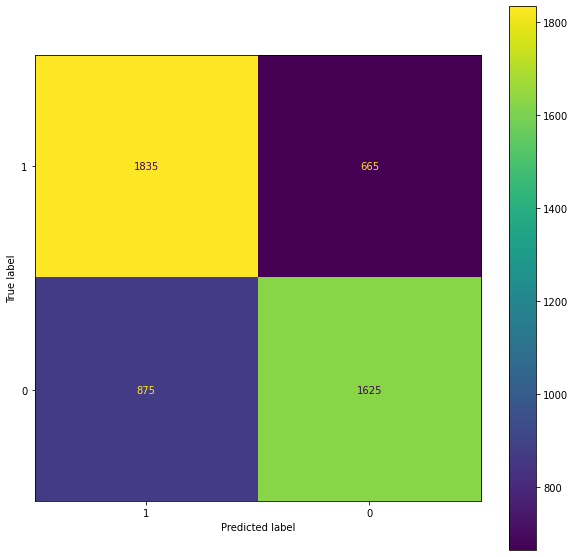

In [98]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=[1,0])
fig, ax = plt.subplots(figsize=(10,10))
disp.plot(ax=ax)


In [99]:
f = open("result.txt", "r")
train_loss = []
for i in f.readlines():
    print((i))
    print(i.split("|")[1].split(" ")[3])
    train_loss.append(i.split("|")[1].split(" ")[3])

Epoch: 1 | Training Loss: 0.6932641837077264  | Validation Loss: 0.6932332011369559  | Accuracy: 49.96

0.6932641837077264
Epoch: 2 | Training Loss: 0.6931989040130224  | Validation Loss: 0.6931829559497344  | Accuracy: 49.96

0.6931989040130224
Epoch: 3 | Training Loss: 0.6931738815246484  | Validation Loss: 0.6931667511279767  | Accuracy: 49.96

0.6931738815246484
Epoch: 4 | Training Loss: 0.6931616694499285  | Validation Loss: 0.6931571715917343  | Accuracy: 49.96

0.6931616694499285
Epoch: 5 | Training Loss: 0.6931584240534366  | Validation Loss: 0.6931518285702436  | Accuracy: 49.96

0.6931584240534366
Epoch: 1 | Training Loss: 0.6931522687276205  | Validation Loss: 0.6931500954505725  | Accuracy: 49.96

0.6931522687276205
Epoch: 2 | Training Loss: 0.693154282676868  | Validation Loss: 0.693149562065418  | Accuracy: 49.96

0.693154282676868
Epoch: 3 | Training Loss: 0.6931474166802871  | Validation Loss: 0.6931479114752549  | Accuracy: 50.04

0.6931474166802871
Epoch: 4 | Training

IndexError: list index out of range

In [101]:
len(train_loss)

1154